In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
cd '/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting'

/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting


In [3]:
### %load src/reg_model_class.py
import numpy as np
import pandas as pd

import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from scipy.interpolate import make_interp_spline

import matplotlib.pyplot as plt
import matplotlib

from matplotlib.dates import (DAILY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)

class reg_model(object):
    def __init__(self, X, y, log_trans_y=False, day_cutoff=70):
        '''
        Day cutoff is split between training and testing data.
        '''
        self.X = X
        if log_trans_y == True:
            elim_invalid = y.copy()
            elim_invalid[elim_invalid < 0] = 0
            self.y = np.log(elim_invalid + 1)
        else:
            self.y = y
        train_mask = self.X['days_elapsed(t)'] < day_cutoff
        holdout_mask = self.X['days_elapsed(t)'] >= day_cutoff
        self.log_trans_y = log_trans_y
        self.X_train, self.X_test, self.y_train, self.y_test = self.X[train_mask], self.X[holdout_mask], self.y[train_mask], self.y[holdout_mask]
        self.error_metric = None

    def lin_reg(self):
        self.model = LinearRegression()
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rmse'

    def log_reg(self):
        self.model = LogisticRegression()
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rmse'

    def ridge_reg(self, alpha=0.5):
        def optimize_alpha(alpha_list):
            pass
        self.model = Ridge(alpha=alpha)
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rss'

    def rand_forest(self, n_trees=50):
        '''
        Upon inspection of the model over time, the number of new cases shows a period of exponential growth, then linear growth where the new cases levels off. Then a random forest model can be applied. 
        '''
        if n_trees == 'optimize':
            '''
            If set to optimize, will take a selection of 1 to max_trees and uses number that minimizes error in training set.
            This can be plotted by uncommenting out the plt.plot(n, error) line.
            '''
            max_trees = 100
            n = np.arange(1, max_trees + 1, 1)
            error = []
            for each in n:
                self.model = RandomForestRegressor(n_estimators=each)
                self.model.fit(self.X_train, self.y_train)
                self.error_metric = 'rmse'
                error.append(self.evaluate_model())
            #plt.plot(n, error)
            n_trees = n[error.index(min(error))]
        self.model = RandomForestRegressor(n_estimators=n_trees, max_depth = None, oob_score = False, warm_start = True, random_state = 500) # max_depth = 3, oob_score = False, random_state = 10
        self.model.fit(self.X_train, self.y_train)    
        self.error_metric = 'rmse'

    def evaluate_model(self, print_err_metric=False):
        self.y_hat = self.model.predict(self.X_test)
        self.predicted_vals_df = pd.DataFrame(self.y_test)
        self.predicted_vals_df['days_elapsed(t)'] = self.X_test['days_elapsed(t)']
        self.predicted_vals_df['y_hat'] = self.y_hat
        self.predicted_vals_df.sort_index(inplace=True)
        if self.error_metric == 'rmse':
            rmse = np.sqrt(mean_squared_error(self.y_test, self.y_hat))
            if print_err_metric:
                print('rmse:', rmse)
            return rmse
        elif self.error_metric == 'rss':
            rss = np.mean((self.y_test - self.y_hat)**2)
            if print_err_metric:
                print('rss: ', rss)
            return rss

    def forecast_vals(self, to_forecast_df):
        self.forecasted = self.model.predict(to_forecast_df)
        return self.forecasted

    def plot_model(self, use_smoothed=True, threshold=100, save_name=None, xvar='days_elapsed(t)', convDate = True):
        '''
        Use smoothed generates data using moving average. 
        Convdate converts days elapsed into date
        '''
        fig, ax = plt.subplots(figsize=(10, 6))
        if self.log_trans_y == True:
            self.y_test = np.e ** self.y_test
        ax.bar(self.X_test.loc[:, xvar].apply(convert_to_date),
               self.y_test, color='blue', label="Test Data")
        ax.bar(self.X_train.loc[:, xvar].apply(convert_to_date), np.e **
               self.y_train, color='red', label="Training Data")
        if use_smoothed == True:
            x, y = create_spline(self.X[xvar], self.y)
            x = pd.DataFrame(x).iloc[:,0].apply(convert_to_date)
            ax.plot_date(x, np.e**y, c='green', label='Moving Average - 7 days', xdate = True, marker = '', ls = '-')
            fig.autofmt_xdate()
            
            rule = rrulewrapper(DAILY, interval=7)
            loc = RRuleLocator(rule)
            formatter = DateFormatter('%y/%m/%d')
            ax.xaxis.set_major_locator(loc)
            ax.xaxis.set_major_formatter(formatter)
            ax.xaxis.set_tick_params(rotation=30, labelsize=14)
            ax.set_xlabel('Date')
#             start_x = convert_to_date(25)
#             ax.set_xlim(start_x)
        else:
            x = self.X_test
            y = self.y
            ax.plot(self.X_test.loc[:, xvar],
                    self.y_test, c='green', label='Predicted Data')
            ax.set_xlabel('Days Since Feb 15')
        try:
            x_thresh = convert_to_date(x[np.where(np.e**y >= threshold)[0][0]])
            ax.axvline(x_thresh, label='Threshold', color='black', ls='--')
        except:
            pass
        ax.legend()
        ax.set_ylabel('Daily Cases per 1 Million Population')
        ax.set_title('New York COVID-19 New Cases')
        fig.tight_layout()
        if save_name != None:
            fig.savefig('images/{}'.format(save_name))


In [4]:
# %load src/data_clean_script.py
import pandas as pd
import numpy as np
import datetime

def create_spline(x, y, t=7, day_delay=0):
    '''
    Use moving average of t points at day_delay
    '''
    y_raw = y.values if day_delay == 0 else y.values[:-day_delay]
    weights = np.repeat(1.0, t) / t
    mov_avgs_y = np.convolve(y_raw, weights, 'valid')
    mov_avgs_x = list(range(x.values[0] + t + day_delay, x.values[-1] + 2))
    return mov_avgs_x, mov_avgs_y[:len(mov_avgs_x) + 1]

def clean_data(df, datetime_col=None):
    clean_df = df.copy()
    if datetime_col != None:
        clean_df[datetime_col] = pd.to_datetime(clean_df[datetime_col])
    return clean_df

def convert_to_date(days_elapsed, original_date= datetime.date(2020, 2, 15)):
    date_result = original_date + datetime.timedelta(days_elapsed)
    return date_result

def replace_initial_values(df, col_change, val_col):
    '''
    When creating new feature columns using difference of existing columns, this function will replace the initial value in val_col of col_change with a 0.
    '''
    prev = None
    for i, st in zip(df.index, df[col_change]):
        if st != prev:
            df.loc[i, val_col] = 0
        else:
            continue
        prev = st
    return df

def replace_with_moving_averages(df, cols, xcol='days_elapsed', day_delay=0):
    '''
    Replaces applicable rows  in columns with weekly average days_past days ago.
    Days_past is an optional parameter if we want to set the moving average to the weekly moving average x number of days ago.

    '''
    df_ma = df.copy()
    for col in cols:
        max_index = max(df_ma.index)
        mv_avgs = create_spline(
            df_ma[xcol], df_ma[col], day_delay=day_delay)[1]
        applicable_row_indices = max_index - len(mv_avgs) + 1
        df_ma.loc[applicable_row_indices:, col] = mv_avgs
    return df_ma

def load_and_clean_data():
    '''
    Sets up and generates dataframe for analysis
    '''

    #Import and clean covid data (Cases in 2020)
    covid_raw_df = pd.read_csv('data/covid-19-data/us-states.csv')
    covid_df = clean_data(covid_raw_df, datetime_col='date')
    covid_df.sort_values(['state', 'date'], inplace=True)
    covid_df['New_Cases'] = covid_df['cases'].diff()

    covid_df = replace_initial_values(covid_df, 'state', 'New_Cases')

    '''
    Mobility Data - From Google
    #The baseline is the median value, for the corresponding day of the week, during the 5-week period Jan 3–Feb 6, 2020
    https://www.google.com/covid19/mobility/index.html?hl=en
    '''

    mobility_raw_df = pd.read_csv(
        'data/Global_Mobility_Report.csv', low_memory=False)
    US_mobility_raw_df = mobility_raw_df[(mobility_raw_df['country_region'] == 'United States') & (
        mobility_raw_df['sub_region_1'].isnull() == False) & (mobility_raw_df['sub_region_2'].isnull() == True)]
    mobility_df = clean_data(US_mobility_raw_df, datetime_col='date')
    mobility_df.reset_index(inplace=True)
    mobility_df.drop(['index', 'country_region_code',
                      'country_region', 'sub_region_2'], axis=1, inplace=True)
    mobility_df.rename(columns=lambda x: x.replace(
        '_percent_change_from_baseline', ''), inplace=True)
    mobility_df.rename(columns={'sub_region_1': 'state'}, inplace=True)
    num_cols = ['retail_and_recreation', 'grocery_and_pharmacy',
                'parks', 'transit_stations', 'workplaces', 'residential']
    mobility_df[num_cols] = mobility_df[num_cols].apply(pd.to_numeric)

    #Convert to percent of normal
    mobility_df[num_cols] = mobility_df[num_cols].apply(
        lambda x: (x + 100)/100)
    states = list(set(mobility_df['state']))
    '''
    Transp data - From Apple
    The CSV file and charts on this site show a relative volume of directions requests per country/region, sub-region or city compared to a baseline volume on January 13th, 2020. We define our day as midnight-to-midnight, Pacific time.
    https://www.apple.com/covid19/mobility 
    '''
    transp_raw_df = pd.read_csv('data/applemobilitytrends-2020-05-09.csv')
    transp_df = transp_raw_df[(transp_raw_df['geo_type'] == 'sub-region')
                              & (transp_raw_df['region'].isin(states))].copy()
    #Driving is only available transportation type data available for statewide data
    transp_df.drop(['geo_type', 'alternative_name', 'transportation_type'],
                   axis=1, inplace=True)
    transp_df.set_index('region', inplace=True)
    transp_df = (transp_df.T) / 100  # Convert to percentage of normal
    transp_df.reset_index(inplace=True)
    transp_df.rename(columns={'index': 'date'}, inplace=True)
    transp_df['date'] = pd.to_datetime(transp_df['date'])
    transp_df = transp_df.melt(id_vars=["date"])
    transp_df.rename(columns={'region': 'state'}, inplace=True)

    mobility_df = mobility_df.merge(transp_df, how='inner', on=['date', 'state'])
    covid_df = mobility_df.merge(covid_df, how='inner', on=['date', 'state'])
    covid_df.rename(columns={'value': 'driving'}, inplace=True)
    covid_df.drop(['cases', 'deaths', 'fips'], axis=1, inplace=True)

    #Converts date into days elapsed since outbreak- some functions don't work with datetime objects
    #February 15th is earliest data
    min_date = datetime.datetime(2020, 2, 15)
    covid_df['date'] = covid_df['date'].apply(
        lambda x: (x.to_pydatetime() - min_date).days)
    dates = covid_df['date']
    covid_df.rename(columns={'date': 'days_elapsed'}, inplace=True)

    #Importing state populations and land areas - going to convert cases to new cases per capita for better comparison, implement state density
    state_pops = pd.read_csv('data/pop_by_state.csv',
                             header=1, usecols=['State', 'Pop'])
    state_area = pd.read_csv('data/state_area.csv',
                             usecols=['State', 'TotalArea'])
    state_pops.rename(columns={'State': 'state'}, inplace=True)
    state_area.rename(columns={'State': 'state'}, inplace=True)
    state_pops = state_pops.merge(state_area, on='state')
    state_pops['pop_density'] = state_pops['Pop'] / state_pops['TotalArea']
    state_pops['Pop'] = state_pops['Pop'] / 1000000
    covid_df = covid_df.merge(state_pops, on='state')
    covid_df['New_Cases_per_pop'] = covid_df['New_Cases'] / covid_df['Pop']
    covid_df.drop(['TotalArea', 'New_Cases', 'Pop'], axis=1, inplace=True)

    #2 missing park values; manually fill them in with average of surrounding value
    covid_df.loc[507, 'parks'] = (
        covid_df.loc[506, 'parks'] + covid_df.loc[508, 'parks'])/2
    covid_df.loc[514, 'parks'] = (
        covid_df.loc[513, 'parks'] + covid_df.loc[515, 'parks'])/2

    return covid_df


In [57]:
# %load src/main.py
'''
See notebooks/EDA.ipynb for plots
'''
import pandas as pd
import numpy as np
import datetime

from scipy.interpolate import make_interp_spline

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({'font.size': 16})
plt.style.use('fivethirtyeight')
plt.close('all')

#Define minimum threshold of cases per 1 million people in each state to begin training data on.
#Threshold is the minimum value at which data is output; Used to reduce misleading predictions
#(low new cases count and low social distancing parameters before pandemic)
threshold = 100

'''
Import scripts from other .py files
'''
# from reg_model_class import reg_model
# from data_clean_script import clean_data, replace_initial_values, replace_with_moving_averages, load_and_clean_data, create_spline, convert_to_date

def state_plot(state, df):
    fig, axes = plt.subplots(8, 1, figsize=(12, 15))
    for i, ax in enumerate(axes, 2):
        query = df[df['state'] == state]['days_elapsed']
        x = query.values
        y = covid_df.loc[query.index].iloc[:, i]
        ax.plot(x, y)
    fig.show()


def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (columns[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def fill_diagonals(df, preds, model, n_interval = 21):
    df.fillna(0, inplace = True)
    n_rows = df.shape[0]
    new_preds = list(preds.values)
    for row in range(n_rows)[:]:
        new_pred = model.predict(df[row:row + 1])[0]
        new_preds.append(new_pred)
        j = 0
        for col in range(n_interval-1,0, -1):
            try:
                df.iloc[row + j, col] = new_pred
                j += 1
            except:
                continue
    new_pred = model.predict(df[-1:-2:-1])[0]
    new_preds.append(new_pred)
    return df, new_preds

def generate_prediction_df(level, total_x, total_y, predictions = 21):
    
    #Part 1: Expands time lagged Daily New Cases columns
    
    columns = ['days_elapsed(t)', 'retail_and_recreation(t)', 'grocery_and_pharmacy(t)', 'parks(t)', 'transit_stations(t)', 'workplaces(t)', 'residential(t)','driving(t)']

    levelDict = {'High': [0.34, 0.5, 0.36, 0.295, 0.4, 1.3, 0.385],
                     'Medium': [0.6, 0.8, 0.7, 0.7, 0.75, 1.1, 0.7],
                     'Low': [1, 1, 1, 1, 1, 0.9, 1]
                     }

    if level not in levelDict.keys():
        pred_params = level
    else:
        pred_params = levelDict[level]
    pred_df = total_x.copy()

    # last_recorded_day = int(test_df['days_elapsed(t)'].max())
    last_recorded_day = 82
    for i in range(last_recorded_day + 1, last_recorded_day + predictions + 1):
        pred_df_row = pd.DataFrame([i] + pred_params).T
        pred_df_row.columns = columns
        pred_df = pred_df.append(pred_df_row, sort=False)
        
    y_pred = total_y
    
    # Part 2: Fills in blank known new cases values
    n_rows = pred_df.shape[0]
    pred_df.fillna(0, inplace = True)
    row_start = 25
    col_start = 20
    new_preds = list(y_pred.values)
    pred_df.iloc[row_start, col_start] = y_pred.values[row_start - 1]
    for row in range(row_start, n_rows):
        for col in range(col_start - 1, -1, -1):
            pred_df.iloc[row, col] = pred_df.iloc[row -1, col + 1]
            
    #Part 3: Fills in rest of time lagged values for future t values, predicting based on prior predictions
    pred_df = fill_diagonals(pred_df,y_pred.loc[:45], rf_model.model, n_interval = 21)[0].loc[42:, :]
    pred_y = fill_diagonals(pred_df,y_pred.loc[:], rf_model.model, n_interval = 21)[1][-pred_df.shape[0]:]
    return pred_df, pred_y

if __name__ == '__main__':
    #Load data, select only New York for now
    covid_df = load_and_clean_data()
    mask1 = (covid_df['state'] == 'New York')
    NY_df = covid_df[mask1]
    y = NY_df.pop('New_Cases_per_pop')
    X = NY_df.iloc[:, 1: -1]
    
    #Calculate moving average, use as target variable instead of raw new cases/pop
    smooth_x, smooth_y = create_spline(X['days_elapsed'], y)
    mov_avg_df = pd.DataFrame([smooth_x, smooth_y]).T
    mov_avg_df.columns = ('days_elapsed', 'Daily New Cases')
    NY_df = replace_with_moving_averages(NY_df, NY_df.columns[2:-1], day_delay = 3)
    mov_avg_df = mov_avg_df[mov_avg_df['Daily New Cases'] >= threshold]
    revised_df = NY_df.merge(mov_avg_df, on = 'days_elapsed').iloc[:, 1:]

    #Only one state is currently considered in this study, no need to compare pop_density
    revised_df.drop('pop_density', axis= 1, inplace = True) 

    #Create time series dataframe, fit it into model and evaluate 
    values = revised_df.values
    ts_frame_data = series_to_supervised(values, revised_df.columns, 21, 1)
    ts_frame_data = ts_frame_data.iloc[:,8:-5:9].join(ts_frame_data.iloc[:, -9:])
    ts_y = ts_frame_data.pop('Daily New Cases(t)')
    ts_x = ts_frame_data
    rf_model = reg_model(ts_x, ts_y)
    rf_model.rand_forest(n_trees= 100)
    rf_model.evaluate_model(print_err_metric = True)

    #Plots in notebooks/EDA.ipynb


rmse: 104.66059091249905


In [61]:
pred_df[0]

,Daily New Cases(t-21),Daily New Cases(t-20),Daily New Cases(t-19),Daily New Cases(t-18),Daily New Cases(t-17),Daily New Cases(t-16),Daily New Cases(t-15),Daily New Cases(t-14),Daily New Cases(t-13),Daily New Cases(t-12),...,Daily New Cases(t-2),Daily New Cases(t-1),days_elapsed(t),retail_and_recreation(t),grocery_and_pharmacy(t),parks(t),transit_stations(t),workplaces(t),residential(t),driving(t)
42,494.844029,470.711968,466.562304,459.616924,439.621889,420.286230,398.835469,378.583826,360.790458,328.761763,...,362.300857,368.545488,79.0,0.421429,0.798571,0.817143,0.342857,0.468571,1.212857,0.577600
43,484.350455,466.562304,459.616924,439.621889,420.286230,398.835469,378.583826,360.790458,328.761763,328.485829,...,368.545488,372.265269,80.0,0.430000,0.805714,0.842857,0.348571,0.472857,1.211429,0.588371
44,467.889946,459.616924,439.621889,420.286230,398.835469,378.583826,360.790458,328.761763,328.485829,332.839045,...,372.265269,377.373685,81.0,0.452857,0.830000,1.027143,0.367143,0.484286,1.204286,0.616614
45,483.960987,439.621889,420.286230,398.835469,378.583826,360.790458,328.761763,328.485829,332.839045,334.993902,...,377.373685,378.606166,82.0,0.464286,0.838571,1.064286,0.372857,0.488571,1.201429,0.630100
0,468.279414,420.286230,398.835469,378.583826,360.790458,328.761763,328.485829,332.839045,334.993902,338.475667,...,378.606166,409.801768,83.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000
0,444.308799,398.835469,378.583826,360.790458,328.761763,328.485829,332.839045,334.993902,338.475667,337.693499,...,409.801768,415.594985,84.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000
0,422.917486,378.583826,360.790458,328.761763,328.485829,332.839045,334.993902,338.475667,337.693499,340.382073,...,415.594985,419.084834,85.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000
0,406.486372,360.790458,328.761763,328.485829,332.839045,334.993902,338.475667,337.693499,340.382073,343.962234,...,419.084834,420.528435,86.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000
0,394.133642,328.761763,328.485829,332.839045,334.993902,338.475667,337.693499,340.382073,343.962234,349.760742,...,420.528435,423.120524,87.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000
0,371.515140,328.485829,332.839045,334.993902,338.475667,337.693499,340.382073,343.962234,349.760742,357.520696,...,423.120524,423.288803,88.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000


In [52]:
def generate_prediction_df(level, total_x, total_y, predictions = 21):
    
    #Part 1: Expands time lagged Daily New Cases columns
    
    columns = ['days_elapsed(t)', 'retail_and_recreation(t)', 'grocery_and_pharmacy(t)', 'parks(t)', 'transit_stations(t)', 'workplaces(t)', 'residential(t)','driving(t)']

    levelDict = {'High': [0.34, 0.5, 0.36, 0.295, 0.4, 1.3, 0.385],
                     'Medium': [0.6, 0.8, 0.7, 0.7, 0.75, 1.1, 0.7],
                     'Low': [1, 1, 1, 1, 1, 0.9, 1]
                     }

    if level not in levelDict.keys():
        pred_params = level
    else:
        pred_params = levelDict[level]
    pred_df = total_x.copy()

    # last_recorded_day = int(test_df['days_elapsed(t)'].max())
    last_recorded_day = 82
    for i in range(last_recorded_day + 1, last_recorded_day + predictions + 1):
        pred_df_row = pd.DataFrame([i] + pred_params).T
        pred_df_row.columns = columns
        pred_df = pred_df.append(pred_df_row, sort=False)
        
    y_pred = total_y
    
    # Part 2: Fills in blank known new cases values
    n_rows = pred_df.shape[0]
    pred_df.fillna(0, inplace = True)
    row_start = 25
    col_start = 20
    new_preds = list(y_pred.values)
    pred_df.iloc[row_start, col_start] = y_pred.values[row_start - 1]
    for row in range(row_start, n_rows):
        for col in range(col_start - 1, -1, -1):
            pred_df.iloc[row, col] = pred_df.iloc[row -1, col + 1]
            
    #Part 3: Fills in rest of time lagged values for future t values, predicting based on prior predictions
    pred_df = fill_diagonals(pred_df,y_pred.loc[:45], rf_model.model, n_interval = 21)[0].loc[42:, :]
    pred_y = fill_diagonals(pred_df,y_pred.loc[:], rf_model.model, n_interval = 21)[1][-pred_df.shape[0]:]
    return pred_df, pred_y

In [53]:
generate_prediction_df('High', ts_x, ts_y)[0]

,Daily New Cases(t-21),Daily New Cases(t-20),Daily New Cases(t-19),Daily New Cases(t-18),Daily New Cases(t-17),Daily New Cases(t-16),Daily New Cases(t-15),Daily New Cases(t-14),Daily New Cases(t-13),Daily New Cases(t-12),...,Daily New Cases(t-2),Daily New Cases(t-1),days_elapsed(t),retail_and_recreation(t),grocery_and_pharmacy(t),parks(t),transit_stations(t),workplaces(t),residential(t),driving(t)
42,494.844029,470.711968,466.562304,459.616924,439.621889,420.286230,398.835469,378.583826,360.790458,328.761763,...,362.300857,368.545488,79.0,0.421429,0.798571,0.817143,0.342857,0.468571,1.212857,0.577600
43,484.350455,466.562304,459.616924,439.621889,420.286230,398.835469,378.583826,360.790458,328.761763,328.485829,...,368.545488,372.265269,80.0,0.430000,0.805714,0.842857,0.348571,0.472857,1.211429,0.588371
44,467.889946,459.616924,439.621889,420.286230,398.835469,378.583826,360.790458,328.761763,328.485829,332.839045,...,372.265269,377.373685,81.0,0.452857,0.830000,1.027143,0.367143,0.484286,1.204286,0.616614
45,483.960987,439.621889,420.286230,398.835469,378.583826,360.790458,328.761763,328.485829,332.839045,334.993902,...,377.373685,378.606166,82.0,0.464286,0.838571,1.064286,0.372857,0.488571,1.201429,0.630100
0,468.279414,420.286230,398.835469,378.583826,360.790458,328.761763,328.485829,332.839045,334.993902,338.475667,...,378.606166,409.801768,83.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000
0,444.308799,398.835469,378.583826,360.790458,328.761763,328.485829,332.839045,334.993902,338.475667,337.693499,...,409.801768,415.594985,84.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000
0,422.917486,378.583826,360.790458,328.761763,328.485829,332.839045,334.993902,338.475667,337.693499,340.382073,...,415.594985,419.084834,85.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000
0,406.486372,360.790458,328.761763,328.485829,332.839045,334.993902,338.475667,337.693499,340.382073,343.962234,...,419.084834,420.528435,86.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000
0,394.133642,328.761763,328.485829,332.839045,334.993902,338.475667,337.693499,340.382073,343.962234,349.760742,...,420.528435,423.120524,87.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000
0,371.515140,328.485829,332.839045,334.993902,338.475667,337.693499,340.382073,343.962234,349.760742,357.520696,...,423.120524,423.288803,88.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000


In [56]:
generate_prediction_df('High', ts_x, ts_y)[1]

[372.26526934979944,
 377.3736852012894,
 378.60616575512796,
 409.8017682304151,
 415.59498531498525,
 419.0848335133124,
 420.5284347821031,
 423.12052392210427,
 423.2888032250073,
 423.241332295018,
 423.241332295018,
 423.241332295018,
 422.97568614654875,
 422.758025318951,
 419.6951950372918,
 417.6717282753972,
 417.6717282753972,
 414.55775284316127,
 413.24429246757643,
 412.02886029726346,
 411.05386912219024,
 409.36394810521995,
 408.46802615718764,
 405.034613987083,
 405.034613987083]

In [95]:
Y_pred = pred_df.pop('Daily New Cases(t)')

In [26]:
n_rows = pred_df.shape[0]
pred_df.fillna(0, inplace = True)
row_start = 25
col_start = 20
new_preds = list(Y_pred.values)
pred_df.iloc[row_start, col_start] = Y_pred.values[row_start - 1]
for row in range(row_start, n_rows):
    for col in range(col_start - 1, -1, -1):
        pred_df.iloc[row, col] = pred_df.iloc[row -1, col + 1]

NameError: name 'pred_df' is not defined

In [ ]:
predicted_df = fill_diagonals(pred_df,Y_pred.loc[:45], rf_model.model, n_interval = 21)[0].loc[42:, :]
pred_y = fill_diagonals(pred_df,Y_pred.loc[:45], rf_model.model, n_interval = 21)[1][21:]

In [101]:
pred_df.iloc[:,0:20]

,Daily New Cases(t-21),Daily New Cases(t-20),Daily New Cases(t-19),Daily New Cases(t-18),Daily New Cases(t-17),Daily New Cases(t-16),Daily New Cases(t-15),Daily New Cases(t-14),Daily New Cases(t-13),Daily New Cases(t-12),Daily New Cases(t-11),Daily New Cases(t-10),Daily New Cases(t-9),Daily New Cases(t-8),Daily New Cases(t-7),Daily New Cases(t-6),Daily New Cases(t-5),Daily New Cases(t-4),Daily New Cases(t-3),Daily New Cases(t-2)
21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,494.844029
24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,494.844029,484.350455
25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,494.844029,484.350455,467.889946
26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,494.844029,484.350455,467.889946,483.960987
27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,494.844029,484.350455,467.889946,483.960987,468.279414
28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,494.844029,484.350455,467.889946,483.960987,468.279414,444.308799
29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,494.844029,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486
30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,494.844029,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372


In [117]:
predicted_df = fill_diagonals(pred_df,Y_pred.loc[:45], rf_model.model, n_interval = 21)[0].loc[42:, :]
pred_y = fill_diagonals(pred_df,Y_pred.loc[:45], rf_model.model, n_interval = 21)[1][21:]

In [118]:
predicted_df

,Daily New Cases(t-21),Daily New Cases(t-20),Daily New Cases(t-19),Daily New Cases(t-18),Daily New Cases(t-17),Daily New Cases(t-16),Daily New Cases(t-15),Daily New Cases(t-14),Daily New Cases(t-13),Daily New Cases(t-12),...,Daily New Cases(t-2),Daily New Cases(t-1),days_elapsed(t),retail_and_recreation(t),grocery_and_pharmacy(t),parks(t),transit_stations(t),workplaces(t),residential(t),driving(t)
42,494.844029,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,...,274.515717,229.513863,79.0,0.421429,0.798571,0.817143,0.342857,0.468571,1.212857,0.577600
43,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,326.719043,...,229.513863,212.509570,80.0,0.430000,0.805714,0.842857,0.348571,0.472857,1.211429,0.588371
44,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,326.719043,309.891113,...,212.509570,201.097441,81.0,0.452857,0.830000,1.027143,0.367143,0.484286,1.204286,0.616614
45,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,326.719043,309.891113,315.431837,...,201.097441,193.873924,82.0,0.464286,0.838571,1.064286,0.372857,0.488571,1.201429,0.630100
0,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,326.719043,309.891113,315.431837,340.666384,...,193.873924,179.382798,83.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000
0,444.308799,422.917486,406.486372,394.133642,371.515140,326.719043,309.891113,315.431837,340.666384,339.299574,...,179.382798,435.768440,84.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000
0,422.917486,406.486372,394.133642,371.515140,326.719043,309.891113,315.431837,340.666384,339.299574,333.494306,...,435.768440,446.048910,85.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000
0,406.486372,394.133642,371.515140,326.719043,309.891113,315.431837,340.666384,339.299574,333.494306,325.859275,...,446.048910,446.048910,86.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000
0,394.133642,371.515140,326.719043,309.891113,315.431837,340.666384,339.299574,333.494306,325.859275,318.944392,...,446.048910,446.048910,87.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000
0,371.515140,326.719043,309.891113,315.431837,340.666384,339.299574,333.494306,325.859275,318.944392,306.900297,...,446.048910,446.048910,88.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000


In [120]:
pred_y

[212.5095703342195,
 201.09744118974552,
 193.87392351491104,
 179.38279751819329,
 435.7684404189455,
 446.04890962249937,
 446.04890962249937,
 446.04890962249937,
 446.04890962249937,
 446.04890962249937,
 446.04890962249937,
 446.04890962249937,
 446.04890962249937,
 446.04890962249937,
 446.04890962249937,
 446.04890962249937,
 448.22551789847694,
 430.26004891431074,
 430.26004891431074,
 430.26004891431074,
 388.7457653413609,
 378.46529613780694,
 366.1404905994221,
 366.1404905994221,
 366.1404905994221]

In [84]:
rf_model.model.predict(pred_df.iloc[21::1, :])

array([309.89111278, 309.89111278, 326.71904307, 326.71904307,
       467.88994648, 467.88994648, 467.88994648, 467.88994648,
       467.88994648, 467.88994648, 467.88994648, 467.88994648,
       467.88994648, 467.88994648, 467.88994648, 467.88994648,
       467.88994648, 467.88994648, 467.88994648, 467.88994648,
       467.88994648, 467.88994648, 467.88994648, 467.88994648,
       467.88994648])

In [194]:
new_pred_df = pred_df.iloc[:,:8].join(pred_df.iloc[:, 8:-5:9])

In [195]:
new_pred_df

,Daily New Cases(t-21),Daily New Cases(t-20),Daily New Cases(t-19),Daily New Cases(t-18),Daily New Cases(t-17),Daily New Cases(t-16),Daily New Cases(t-15),Daily New Cases(t-14),Daily New Cases(t-13),Daily New Cases(t-4)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
41,NaN,494.844029,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,325.859275
42,494.844029,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,318.944392
43,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,306.900297
44,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,326.719043,274.515717


In [12]:
# new_pred_target = new_pred_df.pop('Daily New Cases(t+20)')

In [55]:
new_pred_df[:10]

,days_elapsed(t),retail_and_recreation(t),grocery_and_pharmacy(t),parks(t),transit_stations(t),workplaces(t),residential(t),driving(t),Daily New Cases(t),Daily New Cases(t+1),...,Daily New Cases(t+10),Daily New Cases(t+11),Daily New Cases(t+12),Daily New Cases(t+13),Daily New Cases(t+14),Daily New Cases(t+15),Daily New Cases(t+16),Daily New Cases(t+17),Daily New Cases(t+18),Daily New Cases(t+19)
20,57.0,0.442857,0.772857,0.732857,0.318571,0.428571,1.240000,0.439557,492.543967,494.844029,...,371.515140,326.719043,309.891113,315.431837,340.666384,339.299574,333.494306,325.859275,318.944392,306.900297
21,58.0,0.445714,0.780000,0.785714,0.318571,0.425714,1.240000,0.446186,494.844029,484.350455,...,326.719043,309.891113,315.431837,340.666384,339.299574,333.494306,325.859275,318.944392,306.900297,274.515717
22,59.0,0.438571,0.798571,0.828571,0.318571,0.422857,1.240000,0.451814,484.350455,467.889946,...,309.891113,315.431837,340.666384,339.299574,333.494306,325.859275,318.944392,306.900297,274.515717,229.513863
23,60.0,0.424286,0.807143,0.814286,0.314286,0.420000,1.241429,0.451914,467.889946,483.960987,...,315.431837,340.666384,339.299574,333.494306,325.859275,318.944392,306.900297,274.515717,229.513863,212.509570
24,61.0,0.408571,0.814286,0.785714,0.308571,0.415714,1.244286,0.450243,483.960987,468.279414,...,340.666384,339.299574,333.494306,325.859275,318.944392,306.900297,274.515717,229.513863,212.509570,201.097441
25,62.0,0.397143,0.827143,0.790000,0.305714,0.410000,1.247143,0.452829,468.279414,444.308799,...,339.299574,333.494306,325.859275,318.944392,306.900297,274.515717,229.513863,212.509570,201.097441,193.873924
26,63.0,0.391429,0.851429,0.780000,0.305714,0.408571,1.247143,0.457329,444.308799,422.917486,...,333.494306,325.859275,318.944392,306.900297,274.515717,229.513863,212.509570,201.097441,193.873924,179.382798
27,64.0,0.368571,0.828571,0.781429,0.305714,0.402857,1.247143,0.452029,422.917486,406.486372,...,325.859275,318.944392,306.900297,274.515717,229.513863,212.509570,201.097441,193.873924,179.382798,0.000000
28,65.0,0.344286,0.802857,0.701429,0.295714,0.400000,1.251429,0.444000,406.486372,394.133642,...,318.944392,306.900297,274.515717,229.513863,212.509570,201.097441,193.873924,179.382798,0.000000,0.000000
29,66.0,0.344286,0.791429,0.688571,0.297143,0.402857,1.251429,0.448429,394.133642,371.515140,...,306.900297,274.515717,229.513863,212.509570,201.097441,193.873924,179.382798,0.000000,0.000000,0.000000


In [73]:
Y_pred.loc[:45]

21    494.844029
22    484.350455
23    467.889946
24    483.960987
25    468.279414
26    444.308799
27    422.917486
28    406.486372
29    394.133642
30    371.515140
31    326.719043
32    309.891113
33    315.431837
34    340.666384
35    339.299574
36    333.494306
37    325.859275
38    318.944392
39    306.900297
40    274.515717
41    229.513863
42    212.509570
43    201.097441
44    193.873924
45    179.382798
Name: Daily New Cases(t), dtype: float64

In [58]:
new_pred_df, y_preds = fill_diagonals(new_pred_df, new_rf.model)

In [59]:
new_pred_df

,days_elapsed(t),retail_and_recreation(t),grocery_and_pharmacy(t),parks(t),transit_stations(t),workplaces(t),residential(t),driving(t),Daily New Cases(t),Daily New Cases(t+1),...,Daily New Cases(t+10),Daily New Cases(t+11),Daily New Cases(t+12),Daily New Cases(t+13),Daily New Cases(t+14),Daily New Cases(t+15),Daily New Cases(t+16),Daily New Cases(t+17),Daily New Cases(t+18),Daily New Cases(t+19)
20,57.0,0.442857,0.772857,0.732857,0.318571,0.428571,1.240000,0.439557,492.543967,494.844029,...,371.515140,326.719043,309.891113,315.431837,340.666384,339.299574,333.494306,325.859275,318.944392,306.900297
21,58.0,0.445714,0.780000,0.785714,0.318571,0.425714,1.240000,0.446186,494.844029,484.350455,...,326.719043,309.891113,315.431837,340.666384,339.299574,333.494306,325.859275,318.944392,306.900297,274.515717
22,59.0,0.438571,0.798571,0.828571,0.318571,0.422857,1.240000,0.451814,484.350455,467.889946,...,309.891113,315.431837,340.666384,339.299574,333.494306,325.859275,318.944392,306.900297,274.515717,229.513863
23,60.0,0.424286,0.807143,0.814286,0.314286,0.420000,1.241429,0.451914,467.889946,483.960987,...,315.431837,340.666384,339.299574,333.494306,325.859275,318.944392,306.900297,274.515717,229.513863,212.509570
24,61.0,0.408571,0.814286,0.785714,0.308571,0.415714,1.244286,0.450243,483.960987,468.279414,...,340.666384,339.299574,333.494306,325.859275,318.944392,306.900297,274.515717,229.513863,212.509570,201.097441
25,62.0,0.397143,0.827143,0.790000,0.305714,0.410000,1.247143,0.452829,468.279414,444.308799,...,339.299574,333.494306,325.859275,318.944392,306.900297,274.515717,229.513863,212.509570,201.097441,193.873924
26,63.0,0.391429,0.851429,0.780000,0.305714,0.408571,1.247143,0.457329,444.308799,422.917486,...,333.494306,325.859275,318.944392,306.900297,274.515717,229.513863,212.509570,201.097441,193.873924,179.382798
27,64.0,0.368571,0.828571,0.781429,0.305714,0.402857,1.247143,0.452029,422.917486,406.486372,...,325.859275,318.944392,306.900297,274.515717,229.513863,212.509570,201.097441,193.873924,179.382798,430.524152
28,65.0,0.344286,0.802857,0.701429,0.295714,0.400000,1.251429,0.444000,406.486372,394.133642,...,318.944392,306.900297,274.515717,229.513863,212.509570,201.097441,193.873924,179.382798,430.524152,430.524152
29,66.0,0.344286,0.791429,0.688571,0.297143,0.402857,1.251429,0.448429,394.133642,371.515140,...,306.900297,274.515717,229.513863,212.509570,201.097441,193.873924,179.382798,430.524152,430.524152,430.773852


In [214]:
revised_df

,days_elapsed,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,driving,Daily New Cases
0,37,0.380000,0.630000,0.360000,0.310000,0.430000,1.260000,0.385000,106.229066
1,38,0.470000,0.820000,0.840000,0.370000,0.440000,1.250000,0.444200,146.594053
2,39,0.440000,0.770000,0.620000,0.340000,0.430000,1.260000,0.429100,178.772877
3,40,0.480000,0.820000,1.010000,0.360000,0.430000,1.250000,0.470600,225.810249
4,41,0.460000,0.800000,0.930000,0.360000,0.430000,1.270000,0.520100,256.431203
5,42,0.390000,0.720000,0.480000,0.330000,0.550000,1.180000,0.407800,276.536538
6,43,0.428571,0.748571,0.681429,0.341429,0.464286,1.232857,0.427943,317.048494
7,44,0.438571,0.764286,0.715714,0.341429,0.460000,1.232857,0.432871,327.703734
8,45,0.435714,0.755714,0.687143,0.332857,0.452857,1.234286,0.431071,342.165466
9,46,0.441429,0.762857,0.722857,0.331429,0.447143,1.234286,0.434443,371.155067


In [19]:
rule = rrulewrapper(DAILY, interval=7)
loc = RRuleLocator(rule)
formatter = DateFormatter('%y/%m/%d')

In [20]:
#Import and clean covid data (Cases in 2020)
covid_raw_df = pd.read_csv('data/covid-19-data/us-states.csv')
covid_df = clean_data(covid_raw_df, datetime_col='date')
covid_df.sort_values(['state', 'date'], inplace=True)
covid_df['New_Cases'] = covid_df['cases'].diff()

covid_df = replace_initial_values(covid_df, 'state', 'New_Cases')

In [21]:
covid_df
    #Load data, select only New York for now
covid_df = load_and_clean_data()
mask1 = (covid_df['state'] == 'New York')
NY_df = covid_df[mask1]
y = NY_df.pop('New_Cases_per_pop')
X = NY_df.iloc[:, 1: -1]

In [147]:
NY_Pop = 19440469/ 1000000

In [23]:
covid_raw_df

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0
...,...,...,...,...,...
4739,2020-05-27,Virginia,51,40249,1281
4740,2020-05-27,Washington,53,21565,1106
4741,2020-05-27,West Virginia,54,1947,74
4742,2020-05-27,Wisconsin,55,16565,539


In [148]:
covid_raw_df = pd.read_csv('data/covid-19-data/us-states.csv')
covid_df = covid_raw_df[['date', 'state', 'cases']].copy()
# NY_df = covid_df[covid['state'] == 'New York']

covid_df.sort_values(['state', 'date'], inplace=True)
covid_df['New_Cases'] = covid_df['cases'].diff()

covid_df = replace_initial_values(covid_df, 'state', 'New_Cases')
mask1 = (covid_df['state'] == 'New York')
NY_df = covid_df[mask1]

In [149]:
NY_df

,date,state,cases,New_Cases
246,2020-03-01,New York,1,0.0
261,2020-03-02,New York,1,0.0
276,2020-03-03,New York,2,1.0
293,2020-03-04,New York,11,9.0
313,2020-03-05,New York,22,11.0
...,...,...,...,...
4502,2020-05-23,New York,364745,1754.0
4557,2020-05-24,New York,366346,1601.0
4612,2020-05-25,New York,367625,1279.0
4667,2020-05-26,New York,368669,1044.0


In [150]:
NY_df['New_Cases_per_pop'] = NY_df['New_Cases']/ NY_Pop

/Users/jbud/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [151]:
NY_df['date'] = pd.to_datetime(NY_df['date'])

/Users/jbud/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


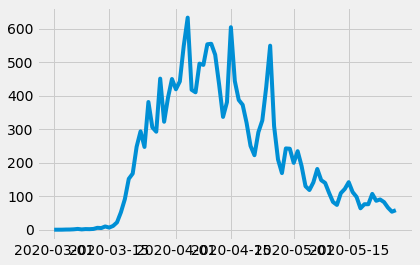

In [152]:
plt.plot(NY_df['date'], NY_df['New_Cases_per_pop'])

In [106]:
predicted_df

,Daily New Cases(t-21),Daily New Cases(t-20),Daily New Cases(t-19),Daily New Cases(t-18),Daily New Cases(t-17),Daily New Cases(t-16),Daily New Cases(t-15),Daily New Cases(t-14),Daily New Cases(t-13),Daily New Cases(t-12),...,Daily New Cases(t-2),Daily New Cases(t-1),days_elapsed(t),retail_and_recreation(t),grocery_and_pharmacy(t),parks(t),transit_stations(t),workplaces(t),residential(t),driving(t)
42,494.844029,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,...,274.515717,229.513863,79.0,0.421429,0.798571,0.817143,0.342857,0.468571,1.212857,0.577600
43,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,326.719043,...,229.513863,212.509570,80.0,0.430000,0.805714,0.842857,0.348571,0.472857,1.211429,0.588371
44,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,326.719043,309.891113,...,212.509570,201.097441,81.0,0.452857,0.830000,1.027143,0.367143,0.484286,1.204286,0.616614
45,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,326.719043,309.891113,315.431837,...,201.097441,193.873924,82.0,0.464286,0.838571,1.064286,0.372857,0.488571,1.201429,0.630100
0,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,326.719043,309.891113,315.431837,340.666384,...,193.873924,179.382798,83.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000
0,444.308799,422.917486,406.486372,394.133642,371.515140,326.719043,309.891113,315.431837,340.666384,339.299574,...,179.382798,435.768440,84.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000
0,422.917486,406.486372,394.133642,371.515140,326.719043,309.891113,315.431837,340.666384,339.299574,333.494306,...,435.768440,446.048910,85.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000
0,406.486372,394.133642,371.515140,326.719043,309.891113,315.431837,340.666384,339.299574,333.494306,325.859275,...,446.048910,446.048910,86.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000
0,394.133642,371.515140,326.719043,309.891113,315.431837,340.666384,339.299574,333.494306,325.859275,318.944392,...,446.048910,446.048910,87.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000
0,371.515140,326.719043,309.891113,315.431837,340.666384,339.299574,333.494306,325.859275,318.944392,306.900297,...,446.048910,446.048910,88.0,0.340000,0.500000,0.360000,0.295000,0.400000,1.300000,0.385000


In [141]:
NY_df['days_elapsed'] = NY_df['days_elapsed'].apply(convert_to_date)
NY_df.rename(columns = {'days_elapsed': 'date'}, inplace = True)

KeyError: 'days_elapsed'

NameError: name 'loc' is not defined

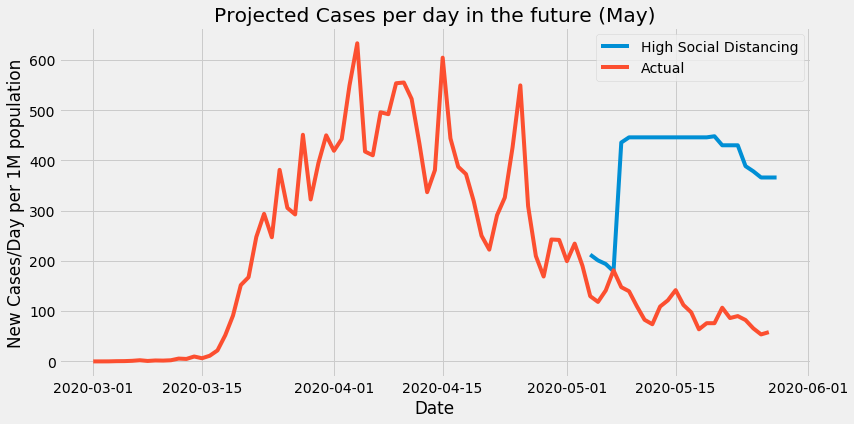

In [154]:
# prediction_ts_hi = generate_prediction_df('High', rf_model.X_test, rf_model.y_test, revised_df.columns)
# prediction_ts_hi['moving_average(t+20)'] = rf_model.model.predict(prediction_ts_hi)

# prediction_ts_md = generate_prediction_df('Medium', rf_model.X_test, rf_model.y_test, revised_df.columns)
# prediction_ts_md['moving_average(t+20)'] = rf_model.model.predict(prediction_ts_md)
fig, ax = plt.subplots(figsize = (12, 6))
X_axis = predicted_df['days_elapsed(t)'].apply(convert_to_date).values
ax.plot(X_axis, pred_y, label = 'High Social Distancing')
# ax.plot(prediction_ts_hi['days_elapsed(t+20)'].apply(convert_to_date) ,prediction_ts_hi['moving_average(t+20)'], label = 'High Social Distance')
# ax.plot(prediction_ts_md['days_elapsed(t+20)'].apply(convert_to_date) ,prediction_ts_md['moving_average(t+20)'], label = 'Medium Social Distance')
# ax.plot(prediction_ts_lw['days_elapsed(t+20)'].apply(convert_to_date) ,prediction_ts_lw['moving_average(t+20)'], label = 'Low Social Distance')
# ax.legend()

ax.plot(NY_df['date'], NY_df['New_Cases_per_pop'], label = 'Actual')
ax.set_title('Projected Cases per day in the future (May)')
ax.set_xlabel('Date')
ax.set_ylabel('New Cases/Day per 1M population')
ax.legend()

ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=14)
fig.autofmt_xdate()
fig.tight_layout()

In [100]:
fig.savefig('images/predicted_vs_actual')

In [26]:
X = new_revised_df

In [27]:
X['days_elapsed(t)'] = X['days_elapsed(t)'].astype(int)

In [28]:
y

2003      0.000000
2004      0.000000
2005      0.051439
2006      0.462952
2007      0.565830
           ...    
2066    190.273187
2067    129.832259
2068    118.412781
2069    141.251736
2070    181.374225
Name: New_Cases_per_pop, Length: 68, dtype: float64

In [13]:
high = [0.34, 0.5, 0.36, 0.295, 0.4, 1.3, 0.385]

In [177]:
new_rf.y

20    492.543967
21    494.844029
22    484.350455
23    467.889946
24    483.960987
25    468.279414
26    444.308799
27    422.917486
28    406.486372
29    394.133642
30    371.515140
31    326.719043
32    309.891113
33    315.431837
34    340.666384
35    339.299574
36    333.494306
37    325.859275
38    318.944392
39    306.900297
40    274.515717
41    229.513863
42    212.509570
43    201.097441
44    193.873924
45    179.382798
Name: Daily New Cases(t), dtype: float64

In [ ]:
last_recorded_day = int(new_rf.y['days_elapsed(t)'].max())

In [168]:
new_rf.y

20    492.543967
21    494.844029
22    484.350455
23    467.889946
24    483.960987
25    468.279414
26    444.308799
27    422.917486
28    406.486372
29    394.133642
30    371.515140
31    326.719043
32    309.891113
33    315.431837
34    340.666384
35    339.299574
36    333.494306
37    325.859275
38    318.944392
39    306.900297
40    274.515717
41    229.513863
42    212.509570
43    201.097441
44    193.873924
45    179.382798
Name: Daily New Cases(t), dtype: float64

In [44]:
ts_frame_data.iloc[-15:]

,days_elapsed(t-20),retail_and_recreation(t-20),grocery_and_pharmacy(t-20),parks(t-20),transit_stations(t-20),workplaces(t-20),residential(t-20),driving(t-20),Daily New Cases(t-20),days_elapsed(t-19),...,driving(t-1),Daily New Cases(t-1),days_elapsed(t),retail_and_recreation(t),grocery_and_pharmacy(t),parks(t),transit_stations(t),workplaces(t),residential(t),driving(t)
31,48.0,0.434286,0.757143,0.614286,0.315714,0.432857,1.241429,0.425971,396.183857,49.0,...,0.518557,371.515140,68.0,0.384286,0.768571,0.722857,0.321429,0.450000,1.235714,0.522500
32,49.0,0.438571,0.767143,0.681429,0.318571,0.430000,1.241429,0.433743,432.867276,50.0,...,0.522500,326.719043,69.0,0.382857,0.764286,0.712857,0.318571,0.451429,1.235714,0.525543
33,50.0,0.442857,0.772857,0.732857,0.318571,0.428571,1.240000,0.439557,458.888106,51.0,...,0.525543,309.891113,70.0,0.394286,0.778571,0.834286,0.331429,0.457143,1.230000,0.546614
34,51.0,0.445714,0.780000,0.785714,0.318571,0.425714,1.240000,0.446186,472.519464,52.0,...,0.546614,315.431837,71.0,0.388571,0.768571,0.735714,0.322857,0.455714,1.231429,0.539600
35,52.0,0.438571,0.798571,0.828571,0.318571,0.422857,1.240000,0.451814,474.701951,53.0,...,0.539600,340.666384,72.0,0.388571,0.768571,0.710000,0.322857,0.457143,1.231429,0.539729
36,53.0,0.424286,0.807143,0.814286,0.314286,0.420000,1.241429,0.451914,481.264109,54.0,...,0.539729,339.299574,73.0,0.401429,0.785714,0.802857,0.332857,0.461429,1.218571,0.556957
37,54.0,0.408571,0.814286,0.785714,0.308571,0.415714,1.244286,0.450243,491.669502,55.0,...,0.556957,333.494306,74.0,0.407143,0.785714,0.804286,0.334286,0.462857,1.217143,0.561171
38,55.0,0.397143,0.827143,0.790000,0.305714,0.410000,1.247143,0.452829,507.520090,56.0,...,0.561171,325.859275,75.0,0.410000,0.784286,0.785714,0.334286,0.464286,1.217143,0.564900
39,56.0,0.391429,0.851429,0.780000,0.305714,0.408571,1.247143,0.457329,508.357812,57.0,...,0.564900,318.944392,76.0,0.421429,0.798571,0.817143,0.342857,0.468571,1.212857,0.577600
40,57.0,0.368571,0.828571,0.781429,0.305714,0.402857,1.247143,0.452029,492.543967,58.0,...,0.577600,306.900297,77.0,0.430000,0.805714,0.842857,0.348571,0.472857,1.211429,0.588371


In [10]:
round(ts_frame_data, 2)

,days_elapsed(t-20),retail_and_recreation(t-20),grocery_and_pharmacy(t-20),parks(t-20),transit_stations(t-20),workplaces(t-20),residential(t-20),driving(t-20),moving_average(t-20),days_elapsed(t-19),...,driving(t-1),moving_average(t-1),days_elapsed(t),retail_and_recreation(t),grocery_and_pharmacy(t),parks(t),transit_stations(t),workplaces(t),residential(t),driving(t)
20,37.0,0.38,0.63,0.36,0.31,0.43,1.26,0.38,106.23,38.0,...,0.46,508.36,57.0,0.37,0.83,0.78,0.31,0.40,1.25,0.45
21,38.0,0.47,0.82,0.84,0.37,0.44,1.25,0.44,146.59,39.0,...,0.45,492.54,58.0,0.34,0.80,0.70,0.30,0.40,1.25,0.44
22,39.0,0.44,0.77,0.62,0.34,0.43,1.26,0.43,178.77,40.0,...,0.44,494.84,59.0,0.34,0.79,0.69,0.30,0.40,1.25,0.45
23,40.0,0.48,0.82,1.01,0.36,0.43,1.25,0.47,225.81,41.0,...,0.45,484.35,60.0,0.35,0.78,0.69,0.30,0.41,1.25,0.46
24,41.0,0.46,0.80,0.93,0.36,0.43,1.27,0.52,256.43,42.0,...,0.46,467.89,61.0,0.35,0.77,0.70,0.30,0.41,1.25,0.47
25,42.0,0.39,0.72,0.48,0.33,0.55,1.18,0.41,276.54,43.0,...,0.47,483.96,62.0,0.36,0.76,0.72,0.31,0.42,1.24,0.48
26,43.0,0.43,0.75,0.68,0.34,0.46,1.23,0.43,317.05,44.0,...,0.48,468.28,63.0,0.35,0.73,0.68,0.31,0.42,1.24,0.48
27,44.0,0.44,0.76,0.72,0.34,0.46,1.23,0.43,327.70,45.0,...,0.48,444.31,64.0,0.37,0.76,0.71,0.31,0.44,1.24,0.50
28,45.0,0.44,0.76,0.69,0.33,0.45,1.23,0.43,342.17,46.0,...,0.50,422.92,65.0,0.39,0.78,0.76,0.32,0.44,1.24,0.52
29,46.0,0.44,0.76,0.72,0.33,0.45,1.23,0.43,371.16,47.0,...,0.52,406.49,66.0,0.38,0.77,0.72,0.32,0.44,1.24,0.51


In [13]:
from matplotlib.dates import (DAILY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)

rule = rrulewrapper(DAILY, interval=7)
loc = RRuleLocator(rule)
formatter = DateFormatter('%y/%m/%d')

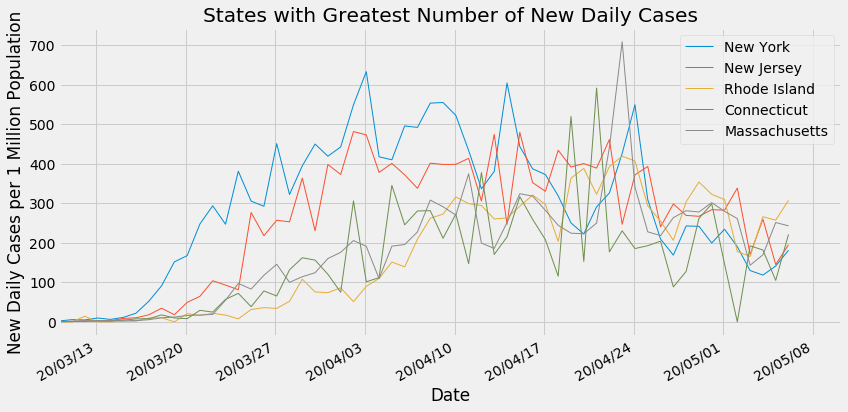

In [14]:
top_states = covid_df[['state','New_Cases_per_pop']].groupby('state').mean()
top_states.sort_values('New_Cases_per_pop', ascending = False, inplace = True)
fig, axes = plt.subplots(figsize = (12,6))
for state in top_states.index[:5]:
    x = covid_df[covid_df['state'] == state].loc[:, 'days_elapsed']
    x = x.apply(convert_to_date)
    y = covid_df[covid_df['state'] == state].loc[:, 'New_Cases_per_pop']
    axes.plot_date(x,y, label = state, linewidth = 1, xdate = True, ls = '-', marker = '')
    fig.autofmt_xdate()
axes.legend()

axes.set_xlabel('Date')
axes.set_ylabel('New Daily Cases per 1 Million Population')
axes.set_title('States with Greatest Number of New Daily Cases')

axes.xaxis.set_major_locator(loc)
axes.xaxis.set_major_formatter(formatter)
axes.xaxis.set_tick_params(rotation=30, labelsize=14)
start_x = convert_to_date(25)
axes.set_xlim(start_x)
fig.tight_layout()

In [21]:
x.iloc[0]

datetime.date(2020, 2, 15)

In [93]:
fig.savefig('images/Top5States')

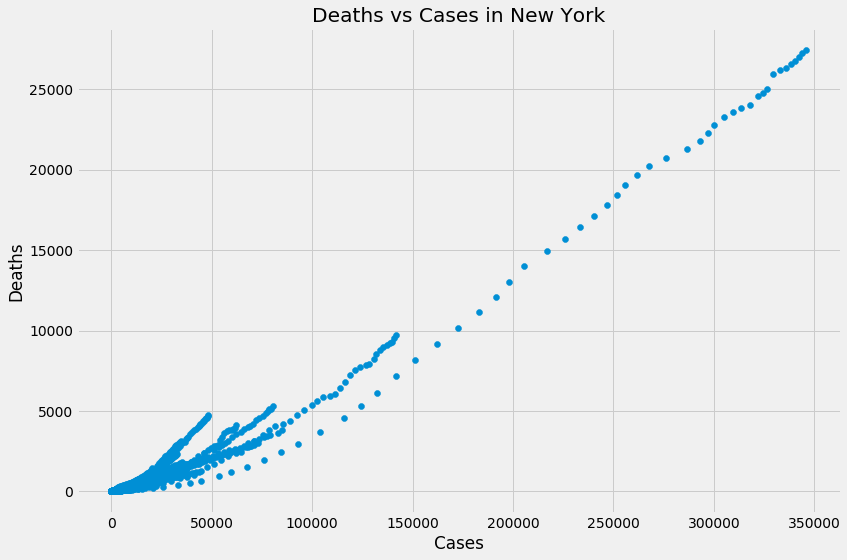

In [94]:
covid_raw_df = pd.read_csv('data/covid-19-data/us-states.csv')
covid_raw_df[covid_raw_df['state'] == 'New York']
fig, ax = plt.subplots(figsize = (12,8))
ax.scatter(covid_raw_df['cases'], covid_raw_df['deaths'])
ax.set_title('Deaths vs Cases in New York')
ax.set_xlabel('Cases')
ax.set_ylabel('Deaths')
fig.tight_layout()
# Mostly linear trend between cases and deaths
fig.savefig('images/DeathVsCases')

In [95]:
revised_df.rename(columns = {'moving_average': 'Daily New Cases'}, inplace = True)

Text(0.5, 0, 'Date')

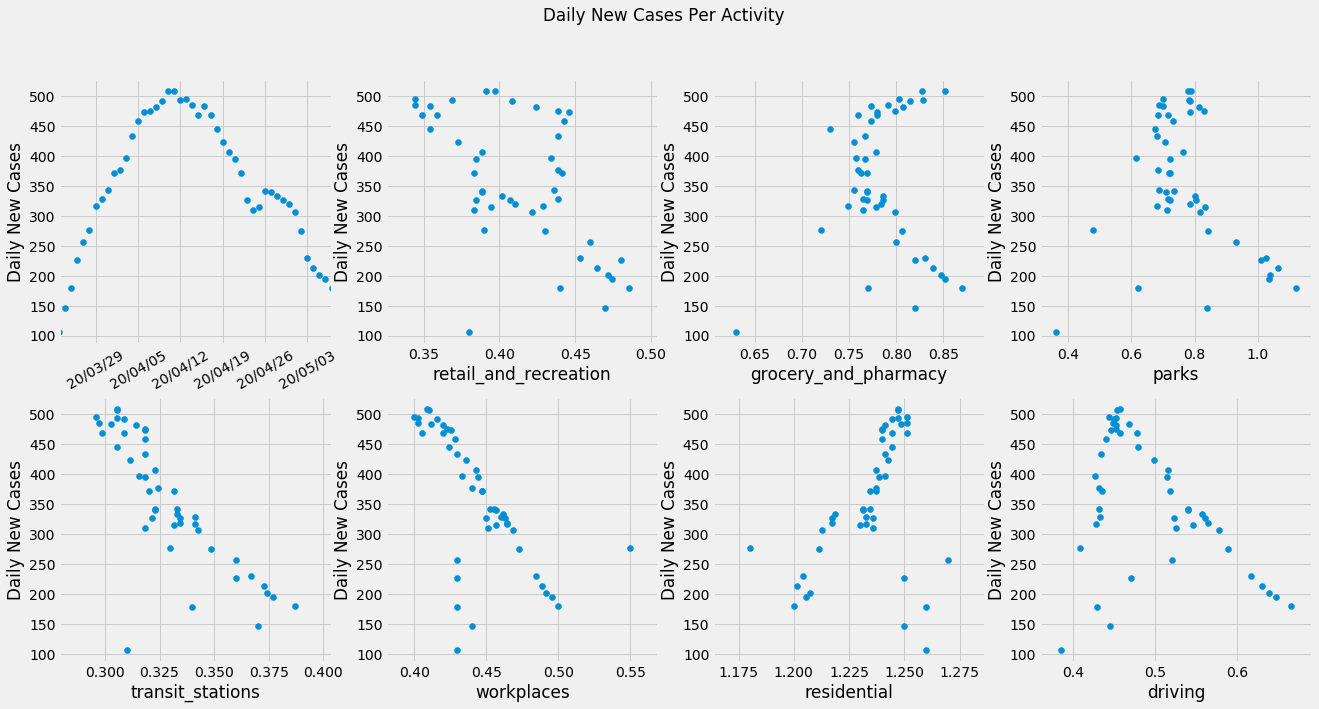

In [96]:
fig, axes = plt.subplots(2, 4, figsize = (20, 10), sharey = False)
y_vals = revised_df['Daily New Cases']
cols = revised_df.columns[:9]

axes.flatten()[0].scatter(revised_df[cols[0]].apply(convert_to_date), y_vals)
axes.flatten()[0].xaxis.set_major_locator(loc)
axes.flatten()[0].xaxis.set_major_formatter(formatter)
axes.flatten()[0].xaxis.set_tick_params(rotation=30, labelsize=14)
start_x = convert_to_date(revised_df['days_elapsed'].min())
end_x = convert_to_date(revised_df['days_elapsed'].max())
axes.flatten()[0].set_xlim(start_x, end_x)
axes.flatten()[0].set_xlabel(cols[i])
axes.flatten()[0].set_ylabel('Daily New Cases')

i = 1
for ax in axes.flatten()[1:]:
    ax.scatter(revised_df[cols[i]], y_vals)
    ax.set_xlabel(cols[i])
    ax.set_ylabel('Daily New Cases')
    i += 1
fig.suptitle('Daily New Cases Per Activity')
axes.flatten()[0].set_xlabel('Date')

In [97]:
fig.savefig('images/CasesperActivit')

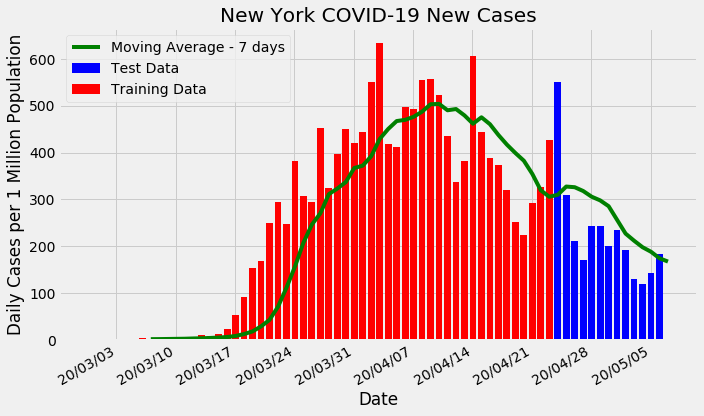

In [122]:
#threshold = 100
X.rename(columns = {'days_elapsed': 'days_elapsed(t)'}, inplace = True)
rf_model = reg_model(X, y, log_trans_y = True)
NY_New_Cases = rf_model.plot_model(save_name = 'NY_New_100', xvar = 'days_elapsed(t)', convDate = True)

In [50]:
from pandas.plotting import scatter_matrix

In [157]:
sm = revised_df.drop('pop_density', axis = 1)

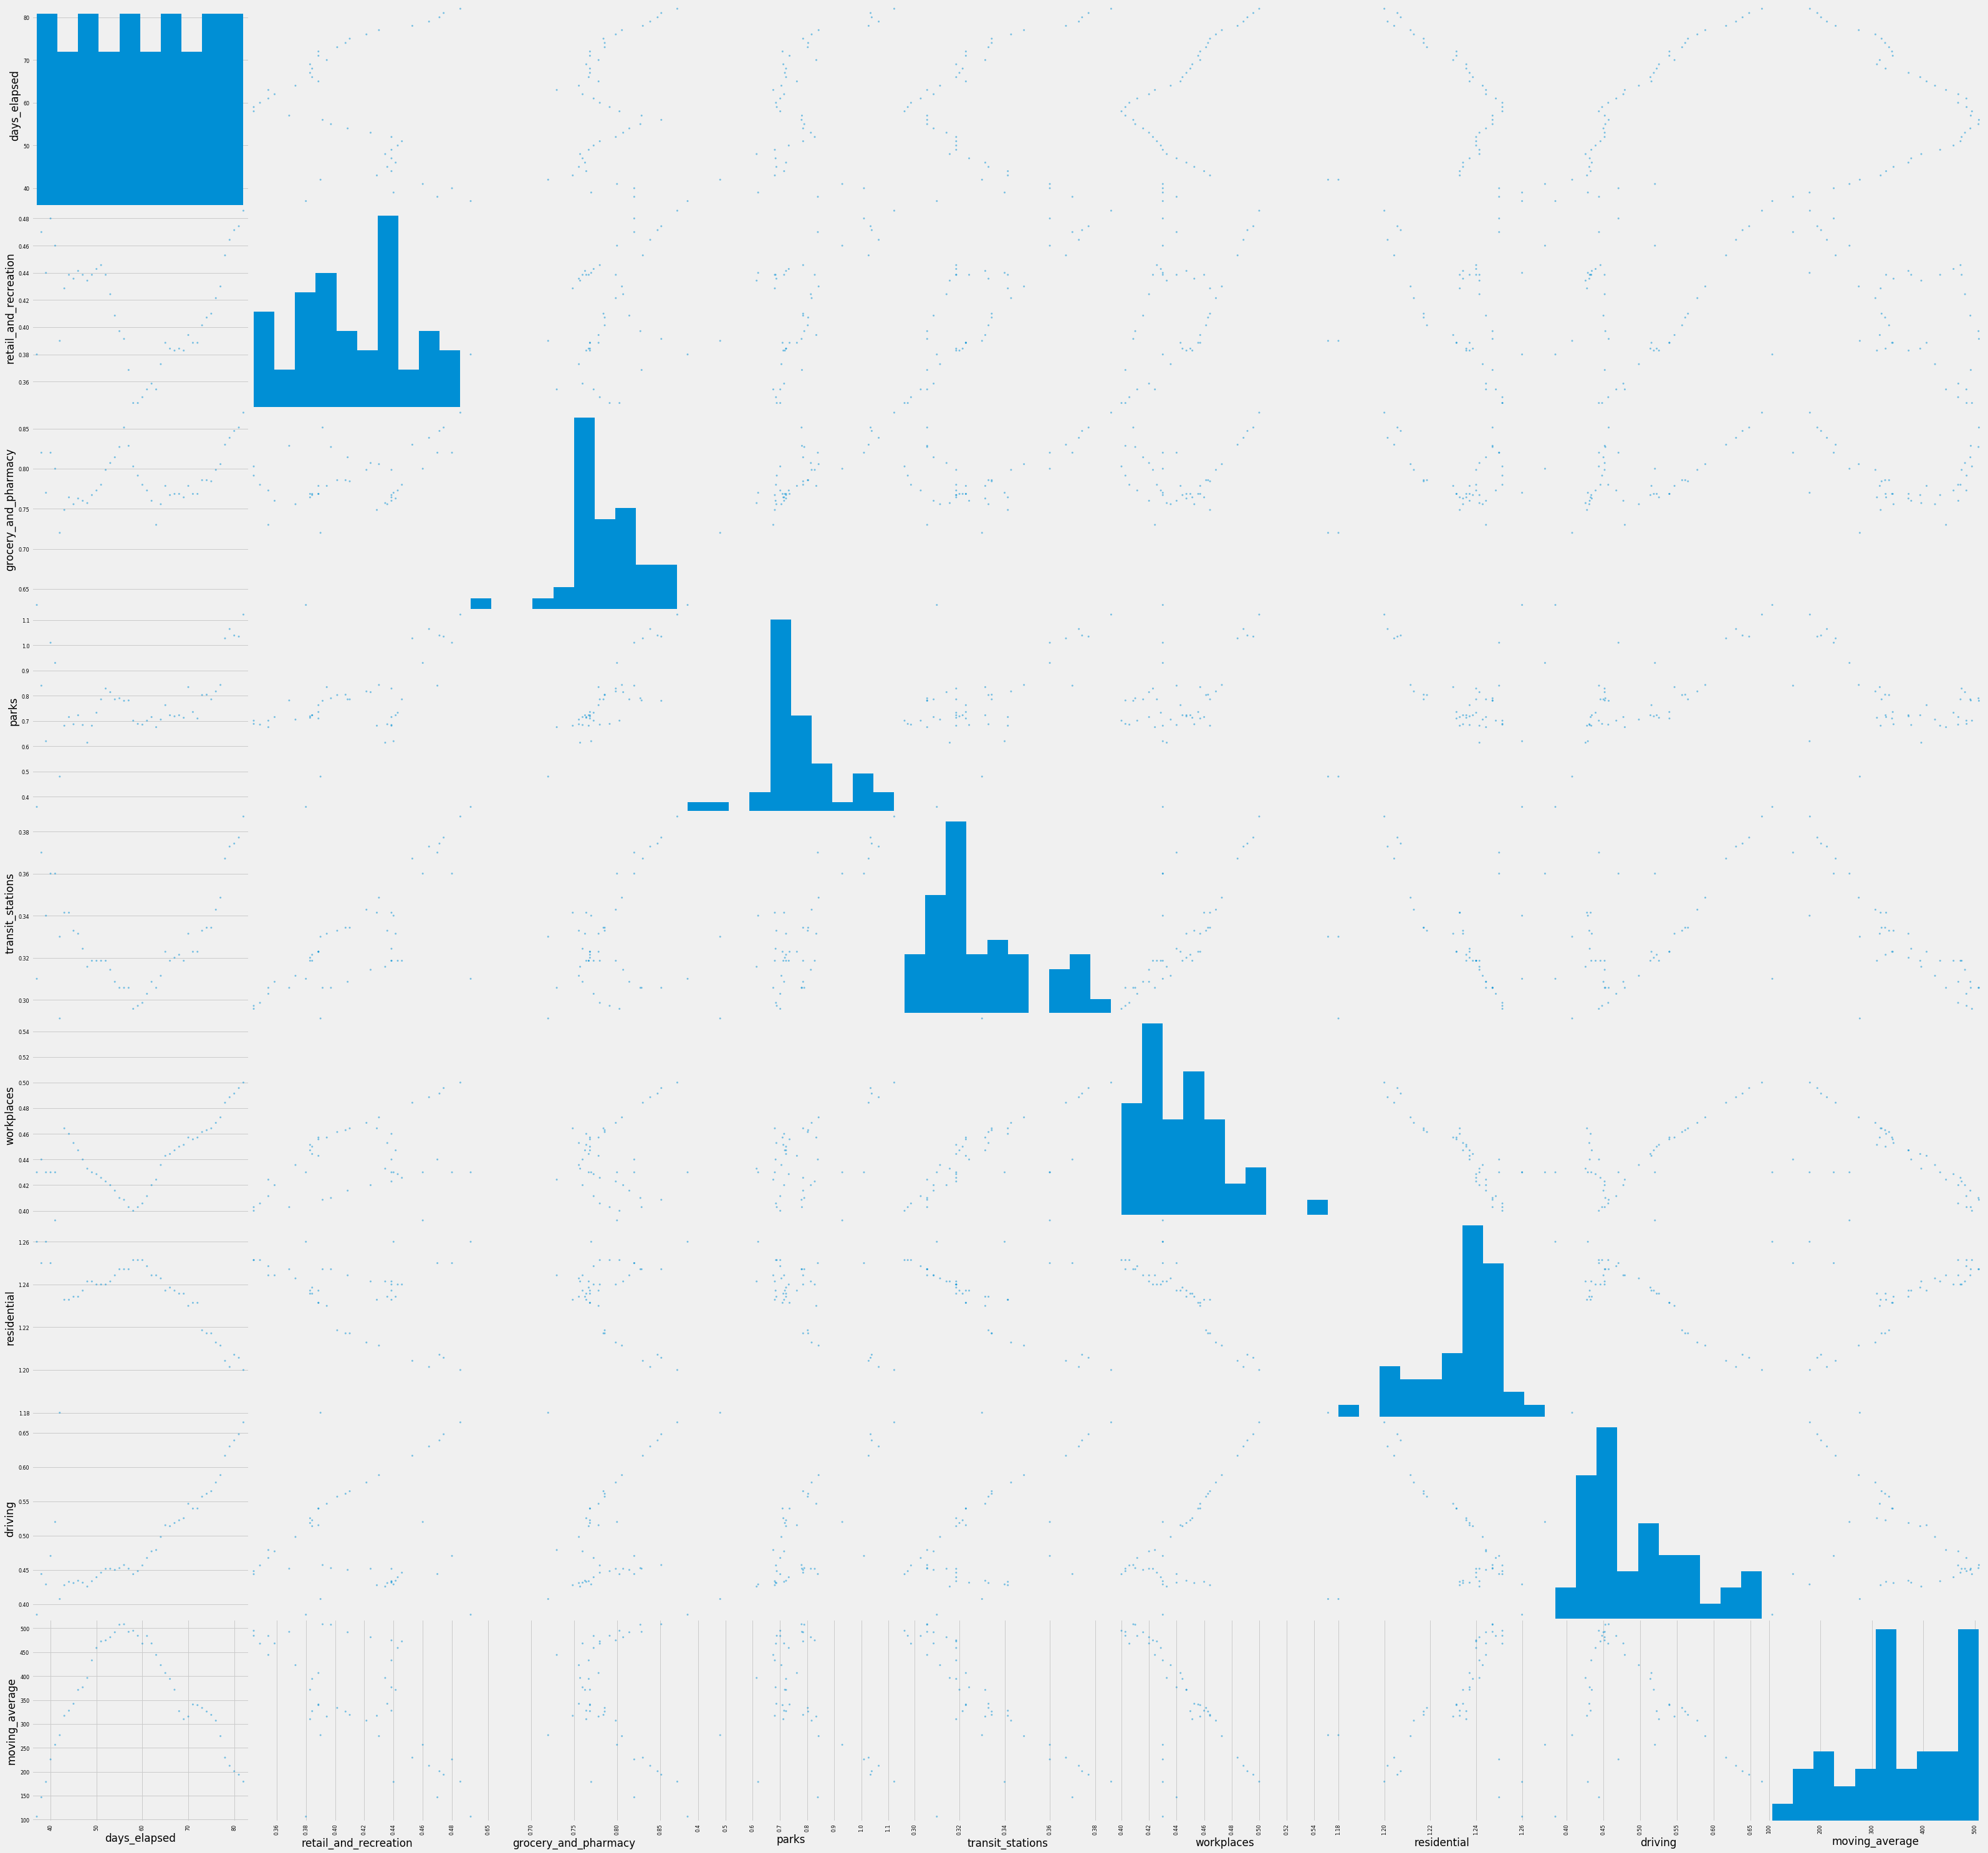

In [84]:
scatter100 = scatter_matrix(sm, figsize = (50,50))

In [86]:
plt.savefig('images/scatter100')

<Figure size 432x288 with 0 Axes>

In [ ]:
X.rename(columns = {'days_elapsed': 'days_elapsed(t)'}, inplace = True)

In [ ]:
#300 Threshold
rf_model = reg_model(X,y, log_trans_y = True)
NY_New_Cases = rf_model.plot_model(save_name = 'NY_New_300', xvar = 'days_elapsed(t)')

In [124]:

X

,days_elapsed(t),retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,driving
2003,15,1.10,1.05,1.09,1.00,1.03,0.99,0.9934
2004,16,1.06,1.05,1.16,0.99,1.04,1.00,1.0288
2005,17,1.04,1.06,1.06,1.00,1.04,1.00,1.0594
2006,18,1.07,1.08,1.16,1.00,1.03,1.00,1.0839
2007,19,1.08,1.09,1.21,1.00,1.04,0.99,1.1334
...,...,...,...,...,...,...,...,...
2066,78,0.50,0.84,1.71,0.43,0.64,1.10,0.6245
2067,79,0.49,0.83,0.89,0.36,0.45,1.23,0.6243
2068,80,0.51,0.91,1.04,0.37,0.45,1.22,0.6745
2069,81,0.46,0.84,0.70,0.35,0.45,1.24,0.6365


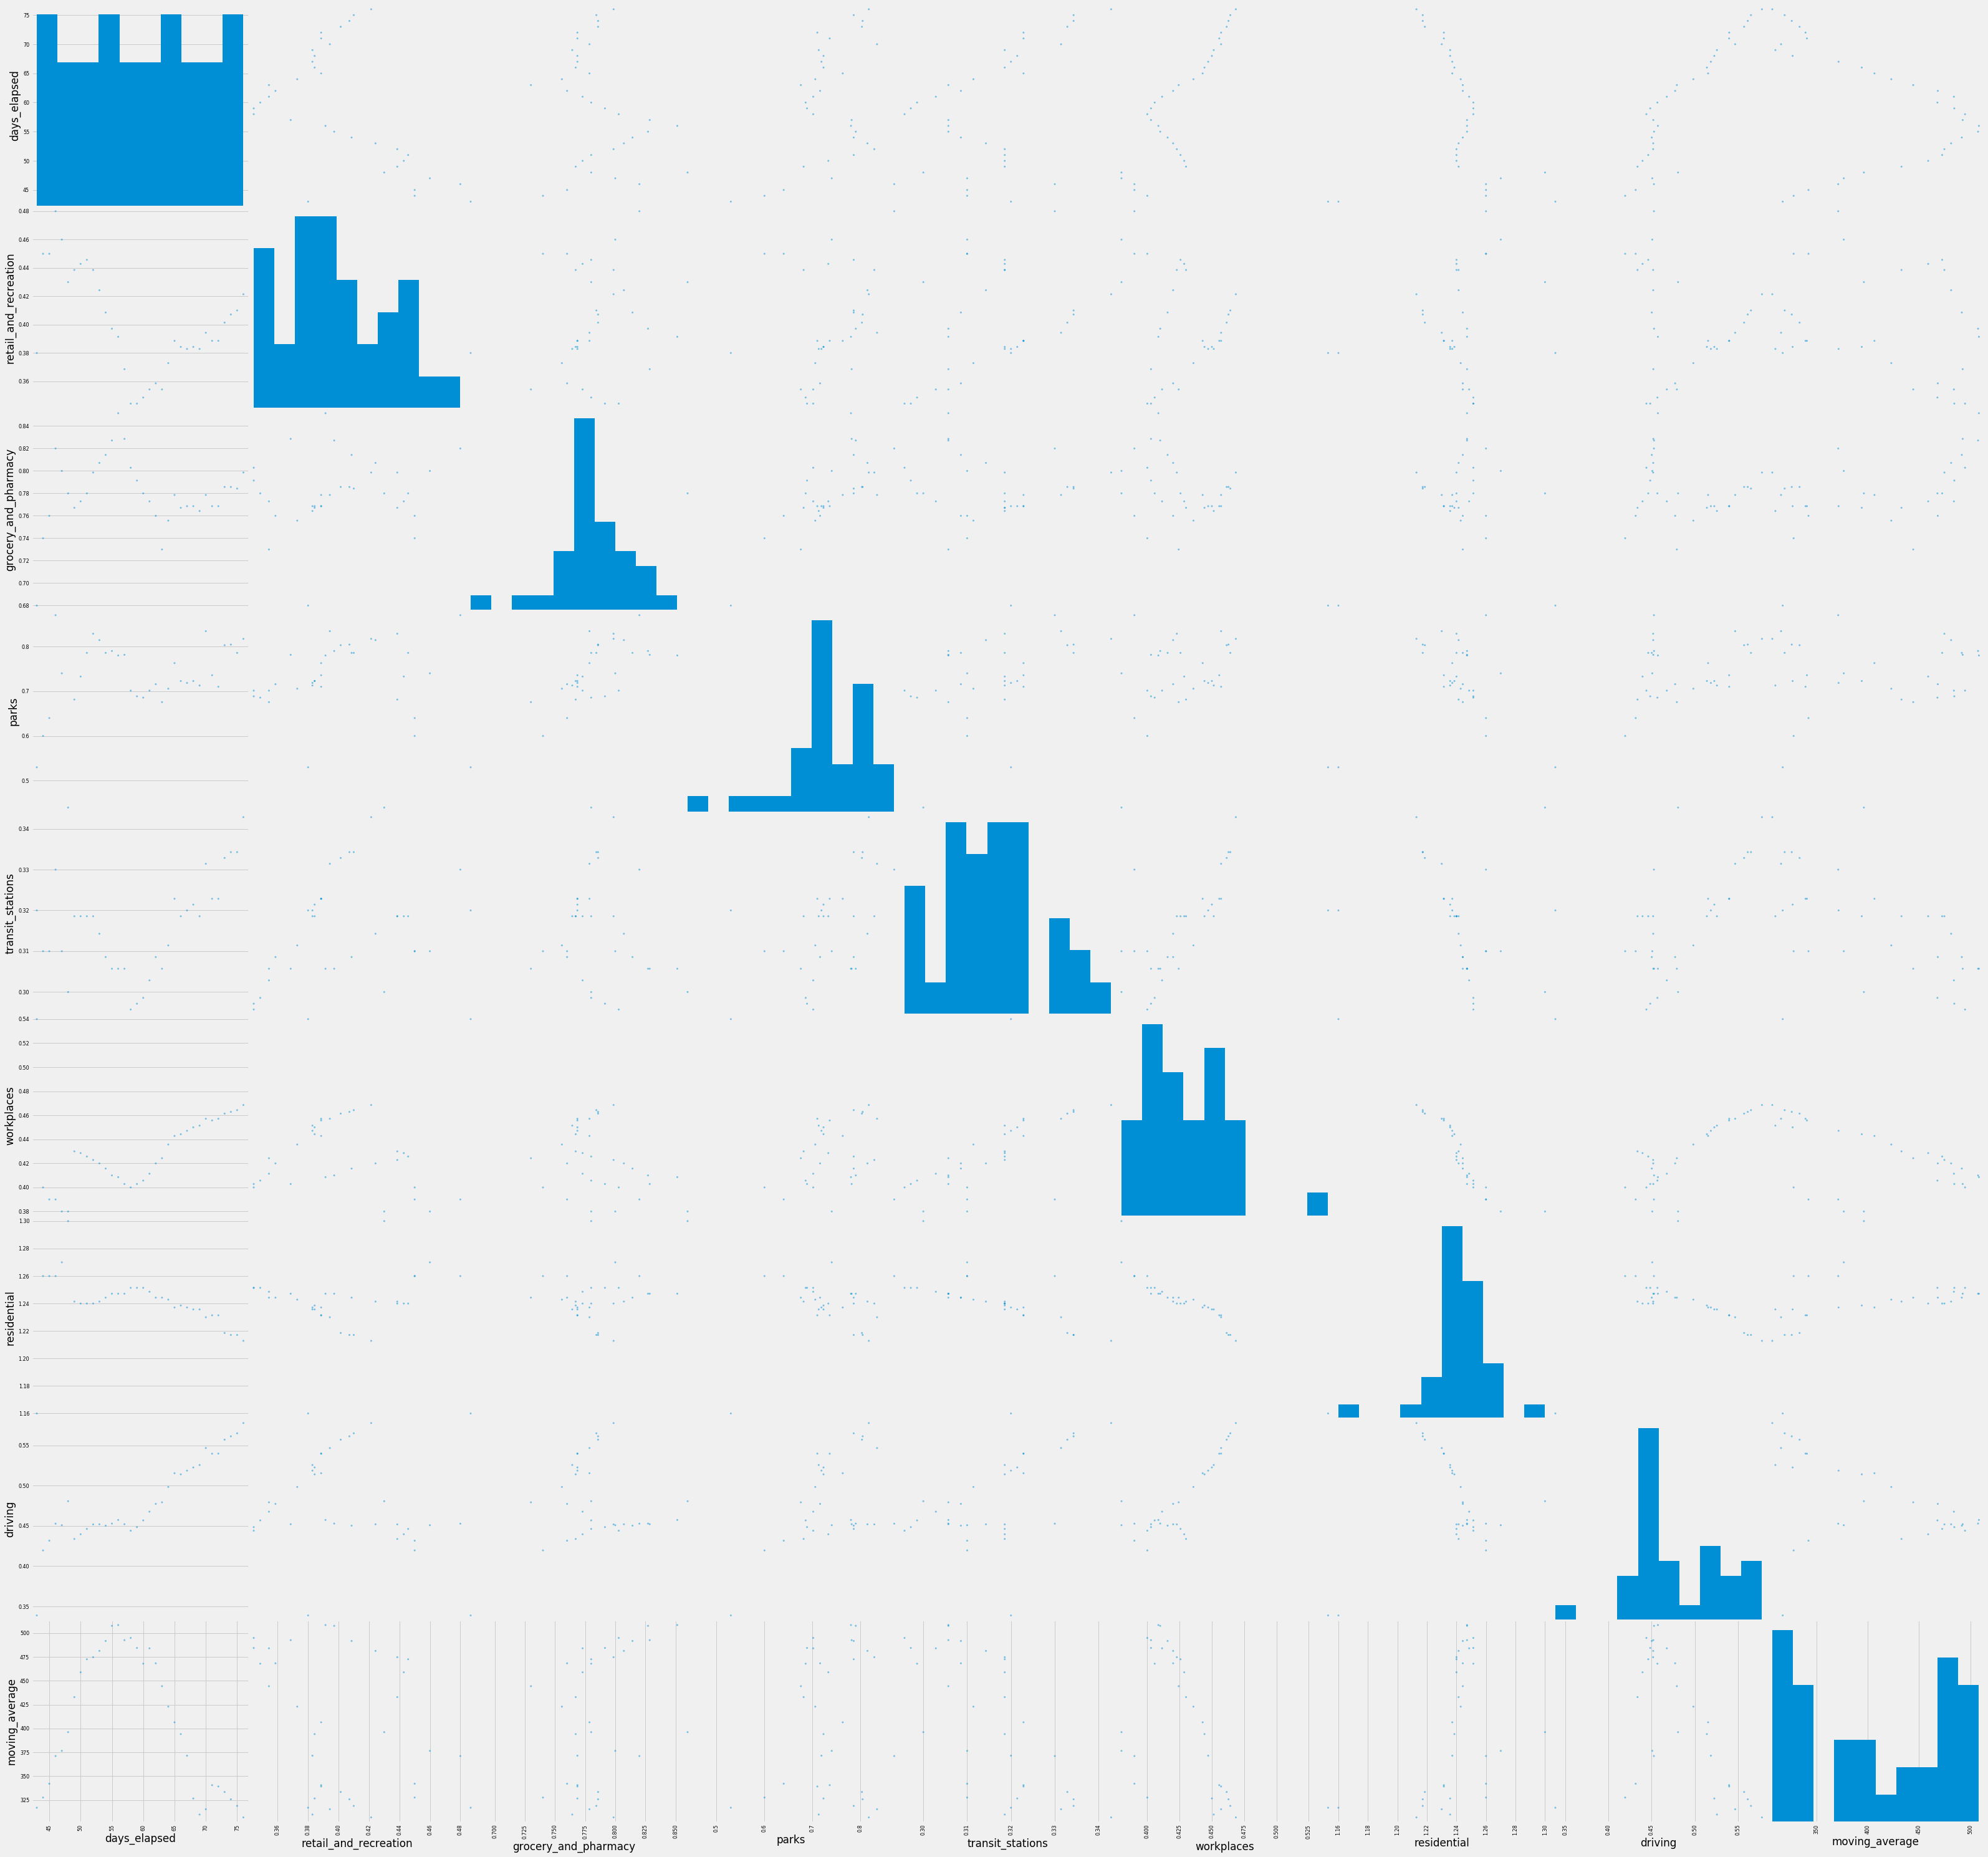

In [148]:
#Using 300 threshold
sm = revised_df.drop('pop_density', axis = 1)
scatter300 = scatter_matrix(sm, figsize = (50,50))

Text(0.5, 0.98, 'Daily New Cases Per Activity (300 Threshold)')

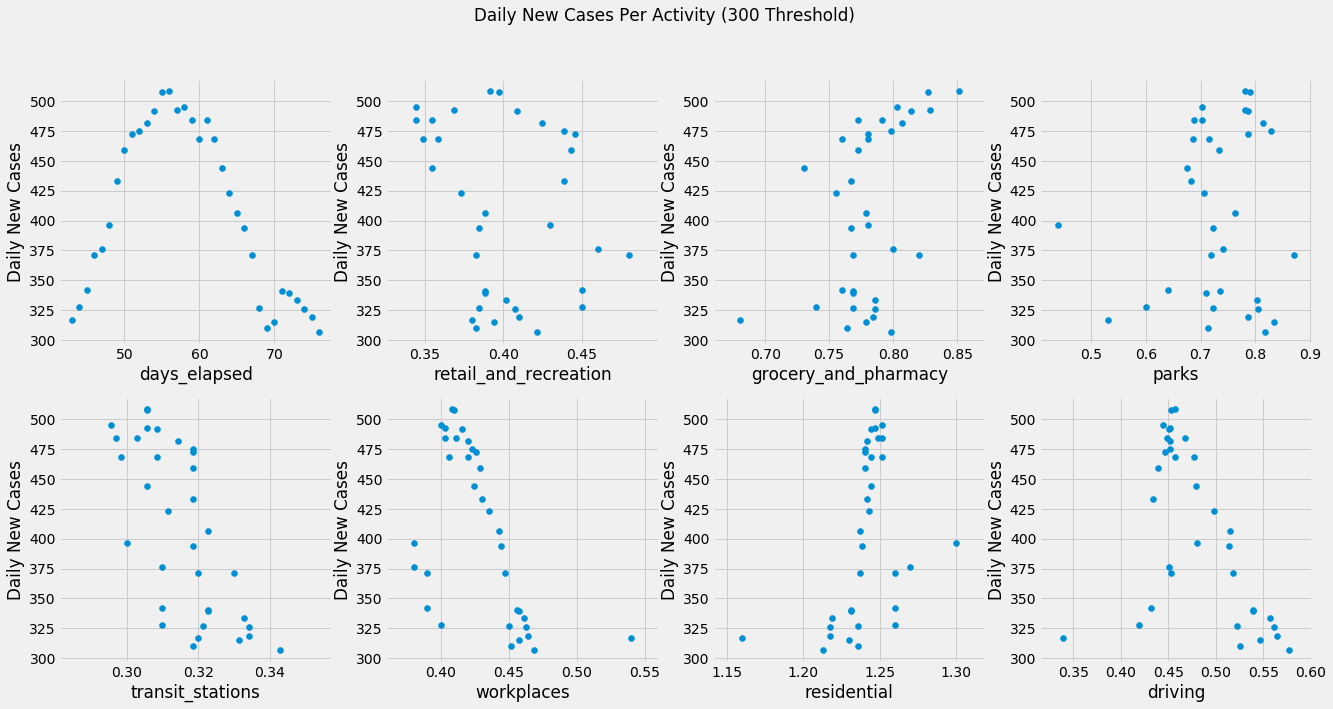

In [64]:
#Using 300 threshold
revised_df.rename(columns = {'moving_average': 'Daily New Cases'}, inplace = True)
fig, axes = plt.subplots(2, 4, figsize = (20, 10))
y_vals = revised_df['Daily New Cases']
cols = revised_df.columns[:9]
i = 0
for ax in axes.flatten():
    ax.scatter(revised_df[cols[i]], y_vals)
    ax.set_xlabel(cols[i])
    ax.set_ylabel('Daily New Cases')
    i += 1
fig.suptitle('Daily New Cases Per Activity (300 Threshold)')

In [66]:
fig.savefig('images/NYSocialDistanceplots.png')

In [14]:
plot_df = revised_df.copy()
plot_df.rename(columns = {'moving_average': "New Cases"})
# plot_df.drop('pop_density', axis = 1, inplace = True)
for col in plot_df.columns[1:]:
    max_val = plot_df[col].max()
    plot_df.loc[:,col] = plot_df[col]/max_val

In [19]:
plot_df.rename(columns = {'moving_average': 'Daily New Cases'}, inplace = True)

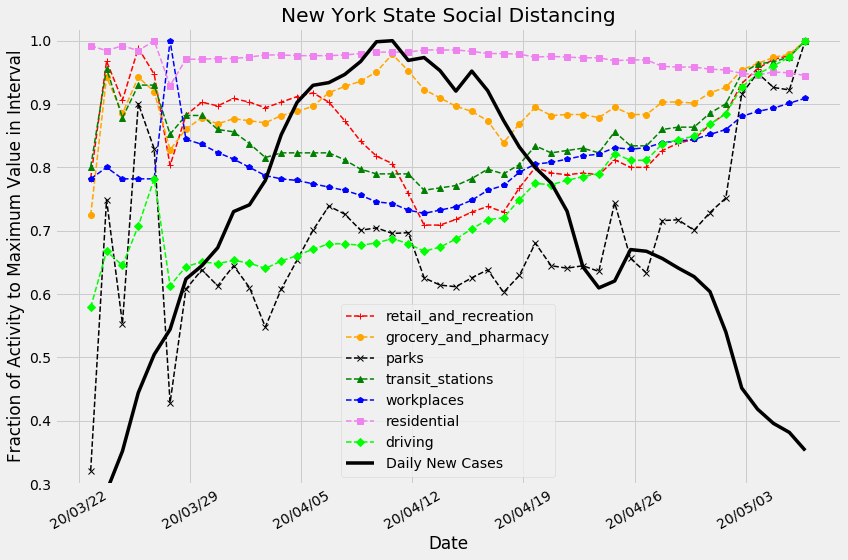

In [23]:
fig, ax = plt.subplots(figsize = (12, 8))
linestyles = ['--', '--', '--', '--', '--', '--', '--', '-']
linewidths = [1.5, 1.5, 1.5, 1.5, 1.5 ,1.5 ,1.5, 3.5]
markers = list('+ox^psD ')
colors = ['red', 'orange', 'black', 'green', 'blue', 'violet', 'lime', 'black']
for i, col in enumerate(plot_df.columns[1:]):
    ax.plot_date(plot_df['days_elapsed'].apply(convert_to_date), plot_df[col], label = col, ls = linestyles[i], linewidth = linewidths[i], c = colors[i], marker = markers[i])
ax.legend()
ax.set_ylim(0.3, 1.02)
ax.set_title('New York State Social Distancing')
ax.set_xlabel('Date')
ax.set_ylabel('Fraction of Activity to Maximum Value in Interval')

ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=14)
# start_x = convert_to_date(25)
# axes.set_xlim(start_x)
fig.tight_layout()


In [25]:
fig.savefig('images/NY_Social_Distance_days')

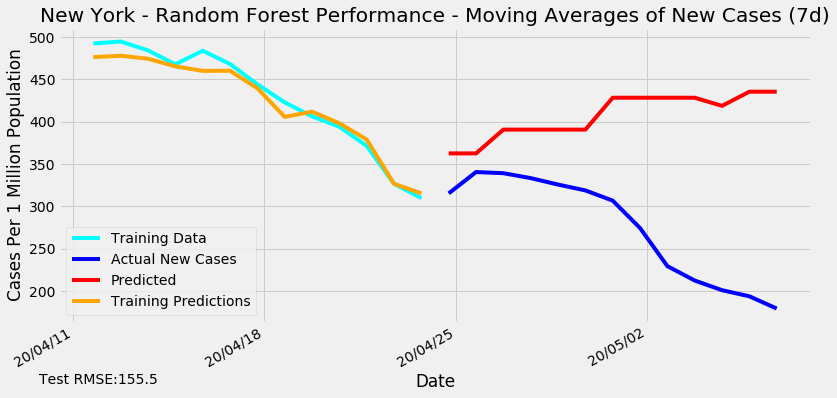

In [15]:
fig, ax = plt.subplots(figsize = (12,6))
ax.plot_date(rf_model.X_train['days_elapsed(t)'].apply(convert_to_date), rf_model.y_train, label = 'Training Data', color = 'cyan', marker = '', ls = '-')
ax.plot_date(rf_model.predicted_vals_df['days_elapsed(t)'].apply(convert_to_date), rf_model.predicted_vals_df['moving_average(t)'], label = 'Actual New Cases', color = 'blue', marker = '', ls = '-')
ax.plot_date(rf_model.predicted_vals_df['days_elapsed(t)'].apply(convert_to_date), rf_model.predicted_vals_df['y_hat'], label = 'Predicted', color = 'red', marker = '', ls = '-')
ax.plot_date(rf_model.X_train['days_elapsed(t)'].apply(convert_to_date), rf_model.model.predict(rf_model.X_train), label = 'Training Predictions', color = 'orange', marker = '', ls = '-')
ax.set_xlabel('Date')
ax.set_ylabel('Cases Per 1 Million Population')
ax.set_title('New York - Random Forest Performance - Moving Averages of New Cases (7d)')
rmse = 'Test RMSE:' + str(round(rf_model.evaluate_model(),1))
ax.text(convert_to_date(55), 90,rmse)
ax.legend()

ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=14)
fig.autofmt_xdate()

In [16]:
fig.savefig('images/RF_Performance')

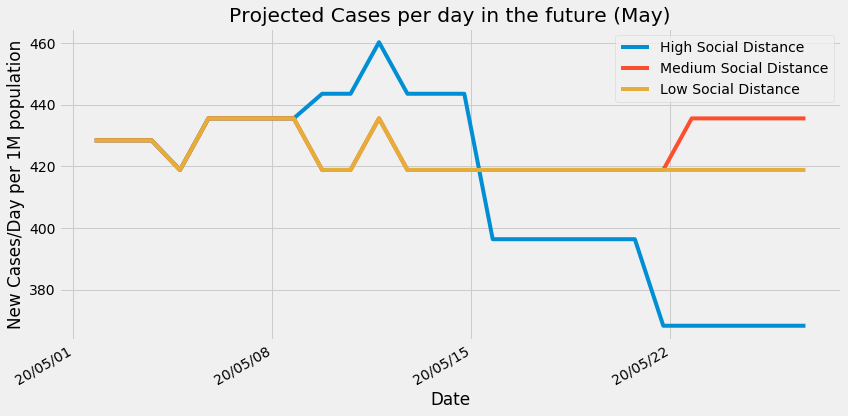

In [58]:
prediction_ts_hi = generate_prediction_df('High', rf_model.X_test, rf_model.y_test, revised_df.columns)
prediction_ts_hi['moving_average(t+20)'] = rf_model.model.predict(prediction_ts_hi)

prediction_ts_md = generate_prediction_df('Medium', rf_model.X_test, rf_model.y_test, revised_df.columns)
prediction_ts_md['moving_average(t+20)'] = rf_model.model.predict(prediction_ts_md)

prediction_ts_lw = generate_prediction_df('Low', rf_model.X_test, rf_model.y_test, revised_df.columns)
prediction_ts_lw['moving_average(t+20)'] = rf_model.model.predict(prediction_ts_lw)

fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(prediction_ts_hi['days_elapsed(t+20)'].apply(convert_to_date) ,prediction_ts_hi['moving_average(t+20)'], label = 'High Social Distance')
ax.plot(prediction_ts_md['days_elapsed(t+20)'].apply(convert_to_date) ,prediction_ts_md['moving_average(t+20)'], label = 'Medium Social Distance')
ax.plot(prediction_ts_lw['days_elapsed(t+20)'].apply(convert_to_date) ,prediction_ts_lw['moving_average(t+20)'], label = 'Low Social Distance')
ax.legend()
ax.set_title('Projected Cases per day in the future (May)')
ax.set_xlabel('Date')
ax.set_ylabel('New Cases/Day per 1M population')

ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=14)
fig.autofmt_xdate()
fig.tight_layout()

In [4]:
fig.savefig('images/Predictions')

NameError: name 'fig' is not defined

In [30]:
rf_model.X_train

,days_elapsed(t-20),retail_and_recreation(t-20),grocery_and_pharmacy(t-20),parks(t-20),transit_stations(t-20),workplaces(t-20),residential(t-20),driving(t-20),Daily New Cases(t-20),days_elapsed(t-19),...,driving(t-1),Daily New Cases(t-1),days_elapsed(t),retail_and_recreation(t),grocery_and_pharmacy(t),parks(t),transit_stations(t),workplaces(t),residential(t),driving(t)
20,37.0,0.380000,0.630000,0.360000,0.310000,0.430000,1.260000,0.385000,106.229066,38.0,...,0.457329,508.357812,57.0,0.368571,0.828571,0.781429,0.305714,0.402857,1.247143,0.452029
21,38.0,0.470000,0.820000,0.840000,0.370000,0.440000,1.250000,0.444200,146.594053,39.0,...,0.452029,492.543967,58.0,0.344286,0.802857,0.701429,0.295714,0.400000,1.251429,0.444000
22,39.0,0.440000,0.770000,0.620000,0.340000,0.430000,1.260000,0.429100,178.772877,40.0,...,0.444000,494.844029,59.0,0.344286,0.791429,0.688571,0.297143,0.402857,1.251429,0.448429
23,40.0,0.480000,0.820000,1.010000,0.360000,0.430000,1.250000,0.470600,225.810249,41.0,...,0.448429,484.350455,60.0,0.348571,0.780000,0.685714,0.298571,0.405714,1.251429,0.456743
24,41.0,0.460000,0.800000,0.930000,0.360000,0.430000,1.270000,0.520100,256.431203,42.0,...,0.456743,467.889946,61.0,0.354286,0.772857,0.701429,0.302857,0.411429,1.248571,0.467614
25,42.0,0.390000,0.720000,0.480000,0.330000,0.550000,1.180000,0.407800,276.536538,43.0,...,0.467614,483.960987,62.0,0.358571,0.760000,0.715714,0.308571,0.420000,1.244286,0.477243
26,43.0,0.428571,0.748571,0.681429,0.341429,0.464286,1.232857,0.427943,317.048494,44.0,...,0.477243,468.279414,63.0,0.354286,0.730000,0.675714,0.305714,0.424286,1.244286,0.479214
27,44.0,0.438571,0.764286,0.715714,0.341429,0.460000,1.232857,0.432871,327.703734,45.0,...,0.479214,444.308799,64.0,0.372857,0.755714,0.705714,0.311429,0.435714,1.242857,0.498286
28,45.0,0.435714,0.755714,0.687143,0.332857,0.452857,1.234286,0.431071,342.165466,46.0,...,0.498286,422.917486,65.0,0.388571,0.778571,0.762857,0.322857,0.442857,1.237143,0.515329
29,46.0,0.441429,0.762857,0.722857,0.331429,0.447143,1.234286,0.434443,371.155067,47.0,...,0.515329,406.486372,66.0,0.384286,0.767143,0.722857,0.318571,0.444286,1.238571,0.513929


In [35]:
rf_model.y_test

33    315.431837
34    340.666384
35    339.299574
36    333.494306
37    325.859275
38    318.944392
39    306.900297
40    274.515717
41    229.513863
42    212.509570
43    201.097441
44    193.873924
45    179.382798
Name: Daily New Cases(t), dtype: float64

In [10]:
new_revised_df

ValueError: Length mismatch: Expected axis has 9 elements, new values have 188 elements

In [28]:
test.head(7)

NameError: name 'test' is not defined

In [35]:
for each in test.columns:
    print(each)

days_elapsed(t)
retail_and_recreation(t)
grocery_and_pharmacy(t)
parks(t)
transit_stations(t)
workplaces(t)
residential(t)
driving(t)
moving_average(t)
days_elapsed(t+1)
retail_and_recreation(t+1)
grocery_and_pharmacy(t+1)
parks(t+1)
transit_stations(t+1)
workplaces(t+1)
residential(t+1)
driving(t+1)
moving_average(t+1)
days_elapsed(t+2)
retail_and_recreation(t+2)
grocery_and_pharmacy(t+2)
parks(t+2)
transit_stations(t+2)
workplaces(t+2)
residential(t+2)
driving(t+2)
moving_average(t+2)
days_elapsed(t+3)
retail_and_recreation(t+3)
grocery_and_pharmacy(t+3)
parks(t+3)
transit_stations(t+3)
workplaces(t+3)
residential(t+3)
driving(t+3)
moving_average(t+3)
days_elapsed(t+4)
retail_and_recreation(t+4)
grocery_and_pharmacy(t+4)
parks(t+4)
transit_stations(t+4)
workplaces(t+4)
residential(t+4)
driving(t+4)
moving_average(t+4)
days_elapsed(t+5)
retail_and_recreation(t+5)
grocery_and_pharmacy(t+5)
parks(t+5)
transit_stations(t+5)
workplaces(t+5)
residential(t+5)
driving(t+5)
moving_average(t+5

In [34]:
test.columns[:] 

Index(['days_elapsed(t)', 'retail_and_recreation(t)',
       'grocery_and_pharmacy(t)', 'parks(t)', 'transit_stations(t)',
       'workplaces(t)', 'residential(t)', 'driving(t)', 'moving_average(t)',
       'days_elapsed(t+1)',
       ...
       'moving_average(t+19)', 'days_elapsed(t+20)',
       'retail_and_recreation(t+20)', 'grocery_and_pharmacy(t+20)',
       'parks(t+20)', 'transit_stations(t+20)', 'workplaces(t+20)',
       'residential(t+20)', 'driving(t+20)', 'moving_average(t+20)'],
      dtype='object', length=189)

In [32]:
147+ 21

168

In [33]:
7 * 21

147

In [ ]:
#show actual values

In [22]:
rf_model

In [9]:
def generate_prediction_df(level, test_df, test_targs, columns, predictions=20):
    '''
    This function generates a prediction array based on the level of social distancing. The predetermined sets
    are determined as follows: High: Minimum values for each column (except residential),
    # Medium: inbetween values, Low: 1 (Back to Normal)
    '''
    levelDict = {'High': [0.34, 0.5, 0.36, 0.295, 0.4, 1.3, 0.385],
                 'Medium': [0.6, 0.8, 0.7, 0.7, 0.75, 1.1, 0.7],
                 'Low': [1, 1, 1, 1, 1, 0.9, 1]
                 }

    if level not in levelDict.keys():
        pred_params = level
    else:
        pred_params = levelDict[level]

    pred_df = rf_model.X.loc[:, 'days_elapsed(t)':].copy()
    pred_df['moving_average'] = rf_model.y
    pred_df.columns = columns
    last_recorded_day = int(test_df['days_elapsed(t)'].max())
    for i in range(last_recorded_day + 1, last_recorded_day + predictions + 1):
        pred_df_row = pd.DataFrame([i] + pred_params).T
        pred_df_row.columns = columns[:-1]
        pred_df = pred_df.append(pred_df_row, sort=True)
    pred_df = pred_df[columns]
    prediction_ts = series_to_supervised(
        pred_df, columns=columns, n_in=0, n_out=21, dropnan=False)
    prediction_ts = prediction_ts[prediction_ts['days_elapsed(t)'] <= 82]

In [15]:
rf_model.X_test.columns

Index(['days_elapsed(t-20)', 'retail_and_recreation(t-20)',
       'grocery_and_pharmacy(t-20)', 'parks(t-20)', 'transit_stations(t-20)',
       'workplaces(t-20)', 'residential(t-20)', 'driving(t-20)',
       'Daily New Cases(t-20)', 'days_elapsed(t-19)',
       ...
       'driving(t-1)', 'Daily New Cases(t-1)', 'days_elapsed(t)',
       'retail_and_recreation(t)', 'grocery_and_pharmacy(t)', 'parks(t)',
       'transit_stations(t)', 'workplaces(t)', 'residential(t)', 'driving(t)'],
      dtype='object', length=188)

In [16]:
generate_prediction_df('High', rf_model.X_test, rf_model.y_test, rf_model.X_test.columns)

ValueError: Length mismatch: Expected axis has 9 elements, new values have 188 elements

In [12]:
test

NameError: name 'test' is not defined

In [90]:
test.iloc[:,8::9]

,moving_average(t),moving_average(t+1),moving_average(t+2),moving_average(t+3),moving_average(t+4),moving_average(t+5),moving_average(t+6),moving_average(t+7),moving_average(t+8),moving_average(t+9),...,moving_average(t+11),moving_average(t+12),moving_average(t+13),moving_average(t+14),moving_average(t+15),moving_average(t+16),moving_average(t+17),moving_average(t+18),moving_average(t+19),moving_average(t+20)
20,492.543967,494.844029,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,...,326.719043,309.891113,315.431837,340.666384,339.299574,333.494306,325.859275,318.944392,306.900297,274.515717
21,494.844029,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,...,309.891113,315.431837,340.666384,339.299574,333.494306,325.859275,318.944392,306.900297,274.515717,229.513863
22,484.350455,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,326.719043,...,315.431837,340.666384,339.299574,333.494306,325.859275,318.944392,306.900297,274.515717,229.513863,212.509570
23,467.889946,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,326.719043,309.891113,...,340.666384,339.299574,333.494306,325.859275,318.944392,306.900297,274.515717,229.513863,212.509570,201.097441
24,483.960987,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,326.719043,309.891113,315.431837,...,339.299574,333.494306,325.859275,318.944392,306.900297,274.515717,229.513863,212.509570,201.097441,193.873924
25,468.279414,444.308799,422.917486,406.486372,394.133642,371.515140,326.719043,309.891113,315.431837,340.666384,...,333.494306,325.859275,318.944392,306.900297,274.515717,229.513863,212.509570,201.097441,193.873924,179.382798
26,444.308799,422.917486,406.486372,394.133642,371.515140,326.719043,309.891113,315.431837,340.666384,339.299574,...,325.859275,318.944392,306.900297,274.515717,229.513863,212.509570,201.097441,193.873924,179.382798,NaN
27,422.917486,406.486372,394.133642,371.515140,326.719043,309.891113,315.431837,340.666384,339.299574,333.494306,...,318.944392,306.900297,274.515717,229.513863,212.509570,201.097441,193.873924,179.382798,NaN,NaN
28,406.486372,394.133642,371.515140,326.719043,309.891113,315.431837,340.666384,339.299574,333.494306,325.859275,...,306.900297,274.515717,229.513863,212.509570,201.097441,193.873924,179.382798,NaN,NaN,NaN
29,394.133642,371.515140,326.719043,309.891113,315.431837,340.666384,339.299574,333.494306,325.859275,318.944392,...,274.515717,229.513863,212.509570,201.097441,193.873924,179.382798,NaN,NaN,NaN,NaN


In [92]:

y = test.pop('moving_average(t+20)')

In [93]:
test.iloc[:6]

,days_elapsed(t),retail_and_recreation(t),grocery_and_pharmacy(t),parks(t),transit_stations(t),workplaces(t),residential(t),driving(t),moving_average(t),days_elapsed(t+1),...,driving(t+19),moving_average(t+19),days_elapsed(t+20),retail_and_recreation(t+20),grocery_and_pharmacy(t+20),parks(t+20),transit_stations(t+20),workplaces(t+20),residential(t+20),driving(t+20)
20,57.0,0.368571,0.828571,0.781429,0.305714,0.402857,1.247143,0.452029,492.543967,58.0,...,0.577600,306.900297,77.0,0.430000,0.805714,0.842857,0.348571,0.472857,1.211429,0.588371
21,58.0,0.344286,0.802857,0.701429,0.295714,0.400000,1.251429,0.444000,494.844029,59.0,...,0.588371,274.515717,78.0,0.452857,0.830000,1.027143,0.367143,0.484286,1.204286,0.616614
22,59.0,0.344286,0.791429,0.688571,0.297143,0.402857,1.251429,0.448429,484.350455,60.0,...,0.616614,229.513863,79.0,0.464286,0.838571,1.064286,0.372857,0.488571,1.201429,0.630100
23,60.0,0.348571,0.780000,0.685714,0.298571,0.405714,1.251429,0.456743,467.889946,61.0,...,0.630100,212.509570,80.0,0.471429,0.847143,1.038571,0.374286,0.491429,1.207143,0.638914
24,61.0,0.354286,0.772857,0.701429,0.302857,0.411429,1.248571,0.467614,483.960987,62.0,...,0.638914,201.097441,81.0,0.474286,0.851429,1.034286,0.377143,0.495714,1.205714,0.647914
25,62.0,0.358571,0.760000,0.715714,0.308571,0.420000,1.244286,0.477243,468.279414,63.0,...,0.647914,193.873924,82.0,0.485714,0.870000,1.121429,0.387143,0.500000,1.200000,0.665271


In [50]:
test.columns

Index(['days_elapsed(t)', 'retail_and_recreation(t)',
       'grocery_and_pharmacy(t)', 'parks(t)', 'transit_stations(t)',
       'workplaces(t)', 'residential(t)', 'driving(t)', 'moving_average(t)',
       'days_elapsed(t+1)',
       ...
       'moving_average(t+19)', 'days_elapsed(t+20)',
       'retail_and_recreation(t+20)', 'grocery_and_pharmacy(t+20)',
       'parks(t+20)', 'transit_stations(t+20)', 'workplaces(t+20)',
       'residential(t+20)', 'driving(t+20)', 'moving_average(t+20)'],
      dtype='object', length=189)

In [73]:
# test.loc[:][1] = 
cols = test.columns.str.split('(')
# cols.apply(lambda x: x[0])

In [74]:
cols.apply(lambda x: x[0])

AttributeError: 'Index' object has no attribute 'apply'

In [82]:
cols

Index([            ['days_elapsed', 't)'],    ['retail_and_recreation', 't)'],
           ['grocery_and_pharmacy', 't)'],                    ['parks', 't)'],
               ['transit_stations', 't)'],               ['workplaces', 't)'],
                    ['residential', 't)'],                  ['driving', 't)'],
                 ['moving_average', 't)'],           ['days_elapsed', 't+1)'],
       ...
              ['moving_average', 't+19)'],          ['days_elapsed', 't+20)'],
       ['retail_and_recreation', 't+20)'],  ['grocery_and_pharmacy', 't+20)'],
                       ['parks', 't+20)'],      ['transit_stations', 't+20)'],
                  ['workplaces', 't+20)'],           ['residential', 't+20)'],
                     ['driving', 't+20)'],        ['moving_average', 't+20)']],
      dtype='object', length=189)

In [38]:
names

Index(['days_elapsed(t-20)', 'retail_and_recreation(t-20)',
       'grocery_and_pharmacy(t-20)', 'parks(t-20)', 'transit_stations(t-20)',
       'workplaces(t-20)', 'residential(t-20)', 'driving(t-20)',
       'moving_average(t-20)', 'days_elapsed(t-19)',
       ...
       'driving(t-1)', 'moving_average(t-1)', 'days_elapsed(t)',
       'retail_and_recreation(t)', 'grocery_and_pharmacy(t)', 'parks(t)',
       'transit_stations(t)', 'workplaces(t)', 'residential(t)', 'driving(t)'],
      dtype='object', length=188)

In [70]:
rf_model.model.predict(test.iloc[5:6])

array([435.57395168])

In [37]:
names = rf_model.X_train.columns  

In [105]:
feat_importances =sorted(zip(map(lambda x: round(x, 4), rf_model.model.feature_importances_), names), reverse=True)
feat_importances = pd.DataFrame(feat_importances)
feat_importances.loc[:][1] = feat_importances.loc[:][1].str.split('(')
feat_importances.loc[:][1] = feat_importances.loc[:][1].apply(lambda x: x[0])
feature_importances = feat_importances.groupby(1).sum()
feature_importances.sort_values(0, ascending = False, inplace = True)
feature_importances.columns = ['Feature Importance']
feature_importances.index = feature_importances.index.rename('')
feature_importances.rename(index = {'moving_average': 'Cases previous day(s)'}, inplace = True)

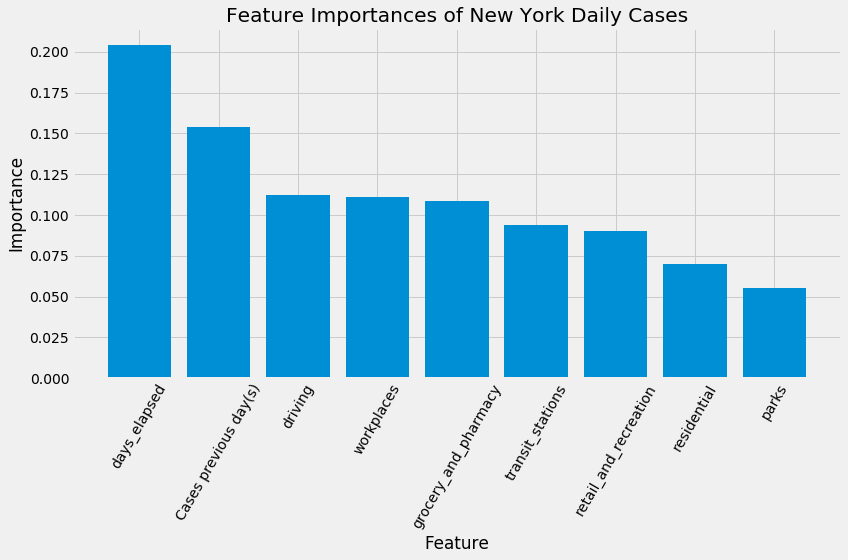

In [106]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.bar(feature_importances.index, feature_importances.values.flatten())
ax.set_xticklabels(feature_importances.index, rotation = 60)
ax.set_xlabel('Feature')
ax.set_ylabel('Importance')
ax.set_title('Feature Importances of New York Daily Cases')
fig.tight_layout()

In [107]:
fig.savefig('images/feature_importances')